In [92]:
import json
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import to_rgba
import seaborn as sns
import requests
from bs4 import BeautifulSoup
from pprint import pprint
import matplotlib.image as mpimg
import matplotlib.patches as patches
from io import BytesIO
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from matplotlib.markers import MarkerStyle
from mplsoccer import Pitch, VerticalPitch, FontManager, Sbopen, add_image
from matplotlib.font_manager import FontProperties
from matplotlib import rcParams
from matplotlib.patheffects import withStroke, Normal
from matplotlib.colors import LinearSegmentedColormap
from mplsoccer.utils import FontManager
import matplotlib.patheffects as path_effects
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data
from sklearn.cluster import KMeans
import warnings
from highlight_text import ax_text, fig_text
from PIL import Image
from urllib.request import urlopen
import os
import time
from unidecode import unidecode
from scipy.spatial import ConvexHull

# Print the modified DataFrame
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

green = '#69f900'
red = '#ff4b44'
blue = '#00a0de'
violet = '#a369ff'
bg_color= '#f5f5f5'
line_color= '#000000'
# bg_color= '#000000'
# line_color= '#ffffff'
hcol = '#ff4b44'
acol = '#00a0de'
path_eff = [path_effects.Stroke(linewidth=3, foreground=bg_color), path_effects.Normal()]

In [2]:
df=pd.read_csv(r"E:\Ai_com\match_enriched\new\match_3925226_.csv")

In [3]:
df.columns.to_list()

['index',
 'period',
 'timestamp',
 'minute',
 'second',
 'possession',
 'duration',
 'type_id',
 'type_name',
 'possession_team_id',
 'possession_team_name',
 'play_pattern_id',
 'play_pattern_name',
 'team_id',
 'team_name',
 'tactics_formation',
 'tactics_lineup',
 'shot_freeze_frame',
 'match_id',
 'obv_for_after',
 'obv_for_before',
 'obv_for_net',
 'obv_against_after',
 'obv_against_before',
 'obv_against_net',
 'obv_total_net',
 'player_id',
 'player_name',
 'position_id',
 'position_name',
 'pass_length',
 'pass_angle',
 'pass_pass_success_probability',
 'pass_recipient_id',
 'pass_recipient_name',
 'pass_height_id',
 'pass_height_name',
 'pass_body_part_id',
 'pass_body_part_name',
 'pass_type_id',
 'pass_type_name',
 'pass_pass_cluster_id',
 'pass_pass_cluster_label',
 'pass_pass_cluster_probability',
 'under_pressure',
 'pass_aerial_won',
 'pass_outcome_id',
 'pass_outcome_name',
 'duel_type_id',
 'duel_type_name',
 'clearance_right_foot',
 'clearance_body_part_id',
 'cleara

In [4]:
# Keep only rows where both columns are valid
valid_rows = df[df['player_id'].notna() & df['tactics_lineup'].notna()].copy()


In [5]:
import ast
import pandas as pd

# Step 1: Grab the two Starting XI rows
lineup_rows = df[df['type_name'] == 'Starting XI']

# Step 2: Build a lookup dictionary {player_id: jersey_number}
player_lineup_lookup = {}

for _, row in lineup_rows.iterrows():
    lineup = ast.literal_eval(row['tactics_lineup'])  # safely parse list
    for player in lineup:
        pid = int(player['player.id'])
        jersey = player['jersey_number']
        player_lineup_lookup[pid] = jersey

# Step 3: Define function to map values
def get_starting_info(pid):
    try:
        pid = int(pid)
        if pid in player_lineup_lookup:
            return pd.Series({'isFirstEleven': True, 'jersey_number': player_lineup_lookup[pid]})
    except:
        pass
    return pd.Series({'isFirstEleven': False, 'jersey_number': None})

# Step 4: Apply to the full DataFrame
df[['isFirstEleven', 'jersey_number']] = df['player_id'].apply(get_starting_info)


In [6]:
# Get the two Starting XI rows
lineup_rows = df[df['type_name'] == 'Starting XI'].reset_index(drop=True)

# Extract home and away team names
hteamName = lineup_rows.loc[0, 'team_name']
ateamName = lineup_rows.loc[1, 'team_name']


In [7]:
import ast

# Get the two Starting XI rows
lineup_rows = df[df['type_name'] == 'Starting XI'].reset_index(drop=True)

# Extract both lineups
players_data = []

for _, row in lineup_rows.iterrows():
    team_lineup = ast.literal_eval(row['tactics_lineup'])
    for player in team_lineup:
        players_data.append({
            'player_id': int(player['player.id']),
            'player_name': player['player.name'],
            'jersey_number': player['jersey_number'],
            'position_name': player['position.name'],
            'isFirstEleven': True,
            'team_name': row['team_name']  # Add team_name for filtering
        })

# Create players_df
players_df = pd.DataFrame(players_data)


In [8]:
# Get all unique player_id + name combinations from the full DataFrame
all_players_info = df[['player_id', 'player_name']].dropna().drop_duplicates()


# Match Report Functions

Pass Network

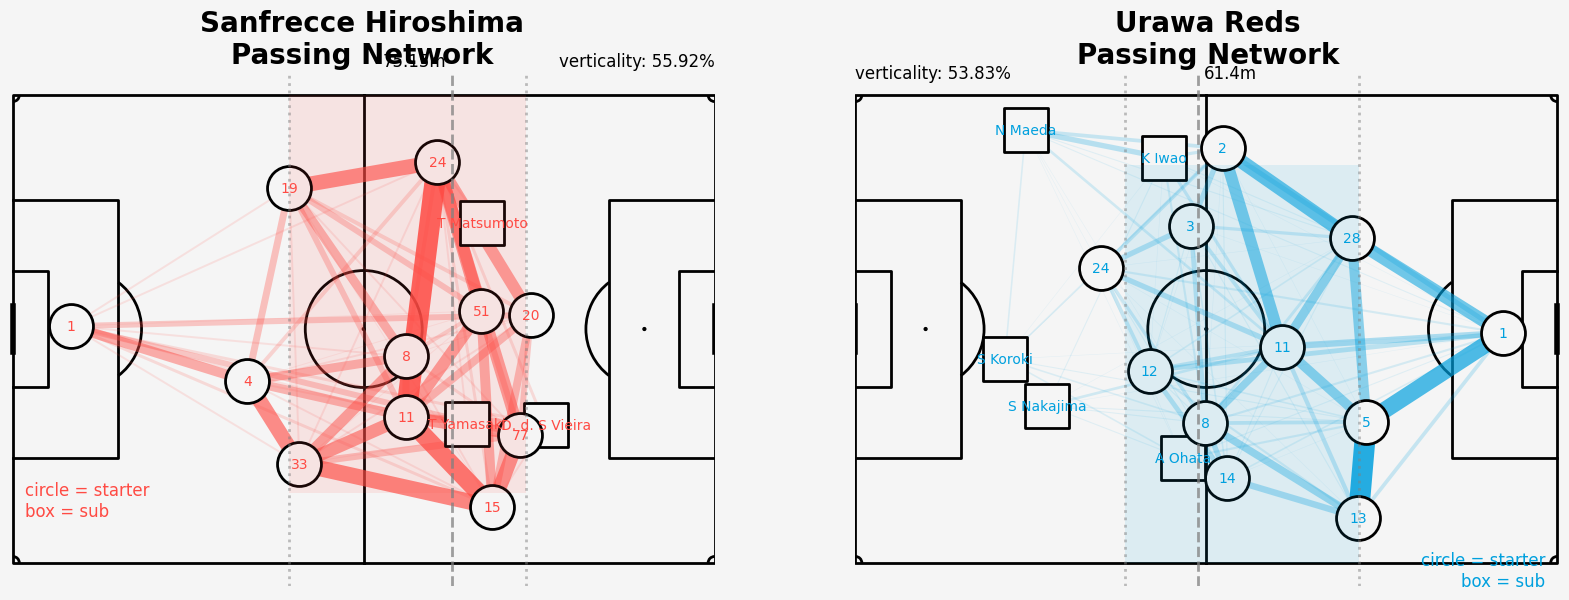

In [9]:
# Create passes_df from full match dataframe
def get_passes_df(df):
    df_filtered = df[~df['type_name'].str.contains(
        'Starting XI|FormationChange|FormationSet|Card|Substitution|Player On|Bad Behaviour|Player Off|Half Start|Half End')]
    return df_filtered[df_filtered['type_name'] == 'Pass'].copy()

passes_df = get_passes_df(df)

# Extract player_id + player_name for full match
all_players_info = df[['player_id', 'player_name']].dropna().drop_duplicates()

# Define function to calculate passes between players
def get_passes_between_df(team_name, passes_df, players_df):
    passes_df = passes_df[passes_df["team_name"] == team_name].copy()
    dfteam = df[(df['team_name'] == team_name) & (~df['type_name'].str.contains(
        'Starting XI|FormationChange|FormationSet|Card|Substitution|Player On|Bad Behaviour|Player Off|Half Start|Half End'))]

    passes_df = passes_df.merge(players_df[["player_id"]], on="player_id", how='left')

    average_locs_and_count_df = dfteam.groupby("player_id").agg({
        'x': 'median', 'y': ['median', 'count']
    })
    average_locs_and_count_df.columns = ['pass_avg_x', 'pass_avg_y', 'count']
    average_locs_and_count_df = average_locs_and_count_df.merge(
        players_df[["player_id", 'jersey_number', "position_name", 'isFirstEleven']],
        on="player_id", how='left'
    ).set_index("player_id")

    passes_player_ids_df = passes_df.loc[:, ['index', "player_id", "pass_recipient_id", 'team_name']].copy()
    passes_player_ids_df.dropna(subset=["player_id", "pass_recipient_id"], inplace=True)
    passes_player_ids_df["player_id"] = passes_player_ids_df["player_id"].astype(int)
    passes_player_ids_df["pass_recipient_id"] = passes_player_ids_df["pass_recipient_id"].astype(int)

    passes_player_ids_df['pos_min'] = passes_player_ids_df[['player_id', 'pass_recipient_id']].min(axis=1)
    passes_player_ids_df['pos_max'] = passes_player_ids_df[['player_id', 'pass_recipient_id']].max(axis=1)

    passes_between_df = passes_player_ids_df.groupby(['pos_min', 'pos_max'])['index'].count().reset_index()
    passes_between_df.rename(columns={'index': 'pass_count'}, inplace=True)

    passes_between_df = passes_between_df.merge(average_locs_and_count_df, left_on='pos_min', right_index=True)
    passes_between_df = passes_between_df.merge(average_locs_and_count_df, left_on='pos_max', right_index=True,
                                                suffixes=['', '_end'])

    return passes_between_df, average_locs_and_count_df

home_passes_between_df, home_average_locs_and_count_df = get_passes_between_df(hteamName, passes_df, players_df)
away_passes_between_df, away_average_locs_and_count_df = get_passes_between_df(ateamName, passes_df, players_df)

# ---- Visualization ----
def pass_network_visualization(ax, passes_between_df, average_locs_and_count_df, col, teamName, flipped=False):
    MAX_LINE_WIDTH = 15
    MIN_TRANSPARENCY = 0.05
    MAX_TRANSPARENCY = 0.85

    passes_between_df['width'] = (passes_between_df.pass_count / passes_between_df.pass_count.max() * MAX_LINE_WIDTH)
    color = np.array(to_rgba(col))
    color = np.tile(color, (len(passes_between_df), 1))
    c_transparency = passes_between_df.pass_count / passes_between_df.pass_count.max()
    c_transparency = (c_transparency * (MAX_TRANSPARENCY - MIN_TRANSPARENCY)) + MIN_TRANSPARENCY
    color[:, 3] = c_transparency

    pitch = Pitch(pitch_type='statsbomb', corner_arcs=True, pitch_color=bg_color, line_color=line_color, linewidth=2)
    pitch.draw(ax=ax)
    ax.set_xlim(-0.5, 120)

    pitch.lines(passes_between_df.pass_avg_x, passes_between_df.pass_avg_y,
                passes_between_df.pass_avg_x_end, passes_between_df.pass_avg_y_end,
                lw=passes_between_df.width, color=color, zorder=1, ax=ax)

    average_locs_and_count_df = average_locs_and_count_df.reset_index().merge(
        all_players_info, on='player_id', how='left'
    ).set_index('player_id')

    for index, row in average_locs_and_count_df.iterrows():
        if row['isFirstEleven'] == True and pd.notna(row["jersey_number"]):
            label = int(row["jersey_number"])
            marker = 'o'
        elif pd.notna(row.get("player_name", None)):
            name_parts = str(row["player_name"]).split()
            label = '. '.join([n[0] for n in name_parts[:-1]]) + f' {name_parts[-1]}' if len(name_parts) > 1 else name_parts[0]
            marker = 's'
        else:
            label = "?"
            marker = 's'

        pitch.scatter(row.pass_avg_x, row.pass_avg_y, s=1000, marker=marker, color=bg_color,
                      edgecolor=line_color, linewidth=2, ax=ax)
        pitch.annotate(label, xy=(row.pass_avg_x, row.pass_avg_y), c=col, ha='center', va='center', size=10, ax=ax)

    avgph = round(average_locs_and_count_df['pass_avg_x'].median(), 2)
    ax.axvline(x=avgph, color='gray', linestyle='--', alpha=0.75, linewidth=2)

    def_line_h = round(
        average_locs_and_count_df[average_locs_and_count_df["position_name"]
        .str.contains("Center Back", case=False, na=False)]['pass_avg_x'].median(), 2)
    ax.axvline(x=def_line_h, color='gray', linestyle='dotted', alpha=0.5, linewidth=2)

    fwd_line_h = round(average_locs_and_count_df[average_locs_and_count_df['isFirstEleven'] == 1]
                       .sort_values(by='pass_avg_x', ascending=False)
                       .head(2)['pass_avg_x'].mean(), 2)
    ax.axvline(x=fwd_line_h, color='gray', linestyle='dotted', alpha=0.5, linewidth=2)
    ax.fill([def_line_h, fwd_line_h, fwd_line_h, def_line_h], [0, 0, 68, 68], col, alpha=0.1)

    team_passes_df = passes_df[passes_df["team_name"] == teamName].copy()
    team_passes_df['pass_or_carry_angle'] = team_passes_df['pass_or_carry_angle'].abs()
    team_passes_df = team_passes_df[(team_passes_df['pass_or_carry_angle'] >= 0) & (team_passes_df['pass_or_carry_angle'] <= 90)]
    verticality = round((1 - team_passes_df['pass_or_carry_angle'].median() / 90) * 100, 2)

    passes_between_df = passes_between_df.merge(
        all_players_info.rename(columns={"player_id": "pos_min", "player_name": "player_name"}), on="pos_min", how="left"
    )
    passes_between_df = passes_between_df.merge(
        all_players_info.rename(columns={"player_id": "pos_max", "player_name": "player_name_end"}), on="pos_max", how="left"
    )

    top_pass = passes_between_df.sort_values(by='pass_count', ascending=False).head(1).reset_index(drop=True)
    most_pass_from = top_pass['player_name'][0] if 'player_name' in top_pass.columns else "?"
    most_pass_to = top_pass['player_name_end'][0] if 'player_name_end' in top_pass.columns else "?"
    most_pass_count = top_pass['pass_count'][0]

    if teamName == ateamName:
        ax.invert_xaxis()
        ax.invert_yaxis()
        ax.text(avgph-1, 83, f"{avgph}m", fontsize=12, color=line_color, ha='left')
        ax.text(120, 83, f"verticality: {verticality}%", fontsize=12, color=line_color, ha='left')
    else:
        ax.text(avgph-1, -5, f"{avgph}m", fontsize=12, color=line_color, ha='right')
        ax.text(120, -5, f"verticality: {verticality}%", fontsize=12, color=line_color, ha='right')

    ax.text(2, 66 if teamName == hteamName else 2, "circle = starter\nbox = sub",
            color=hcol if teamName == hteamName else acol, size=12,
            ha='left' if teamName == hteamName else 'right', va='top')
    ax.set_title(f"{teamName}\nPassing Network", color=line_color, size=20, fontweight='bold')

    return {
        'Team_Name': teamName,
        'Defense_Line_Height': def_line_h,
        'Vericality_%': verticality,
        'Most_pass_combination_from': most_pass_from,
        'Most_pass_combination_to': most_pass_to,
        'Most_passes_in_combination': most_pass_count,
    }

fig, axs = plt.subplots(1, 2, figsize=(20, 10), facecolor=bg_color)
pass_network_stats_home = pass_network_visualization(axs[0], home_passes_between_df, home_average_locs_and_count_df, hcol, hteamName)
pass_network_stats_away = pass_network_visualization(axs[1], away_passes_between_df, away_average_locs_and_count_df, acol, ateamName)
pass_network_stats_df = pd.DataFrame([pass_network_stats_home, pass_network_stats_away])

In [10]:
pass_network_stats_df

,Team_Name,Defense_Line_Height,Vericality_%,Most_pass_combination_from,Most_pass_combination_to,Most_passes_in_combination
0,Sanfrecce Hiroshima,47.30,55.92,Shunki Higashi,Makoto Mitsuta,21
1,Urawa Reds,33.85,53.83,Marius Høibråten,Ryoma Watanabe,39


Defensive Block

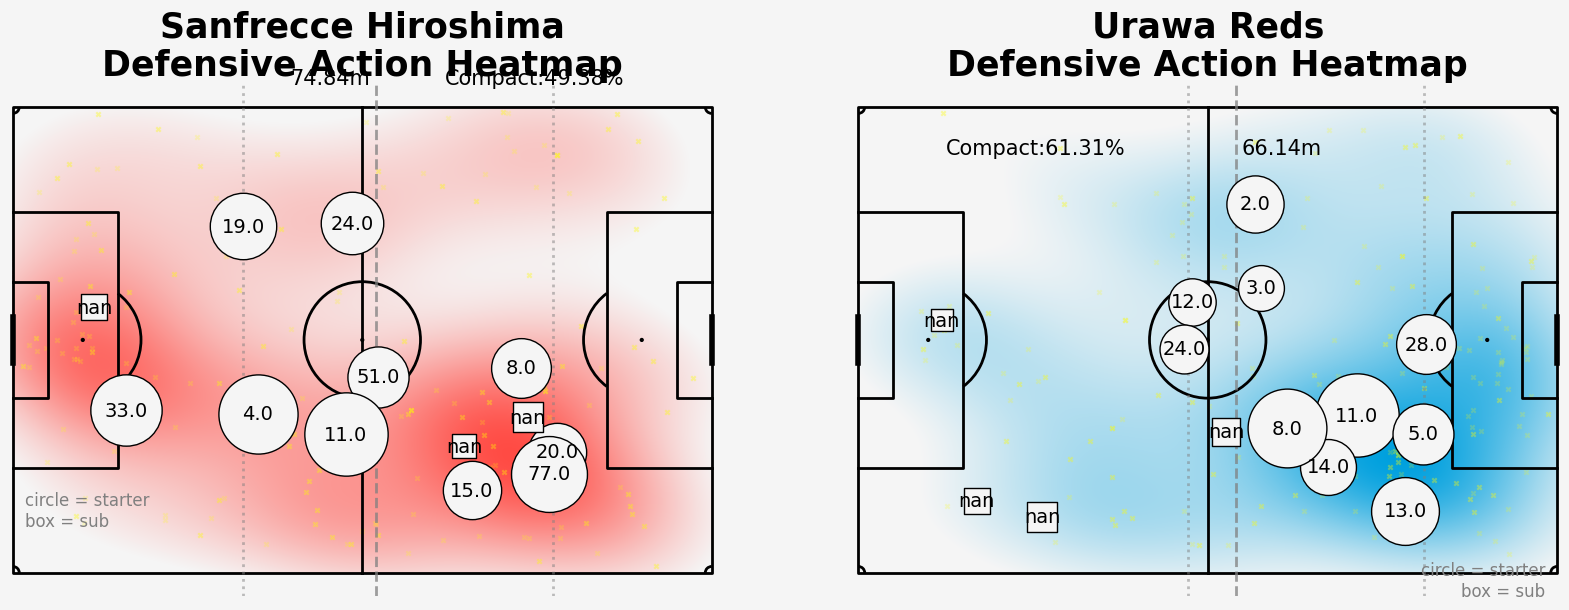

In [ ]:
def get_defensive_action_df(df):
    playerdf = df.copy()
    # Ball Wins
    ball_wins = playerdf[
        (playerdf["type_name"] == 'Interception') |
        (playerdf["type_name"] == 'Ball Recovery')
    ]

    # Tackles (total and unsuccessful)
    tk = playerdf[
        (playerdf["type_name"] == 'Duel') &
        (playerdf['duel_type_name'].str.contains('Tackle', case=False, na=False))
    ]

    tk_u = playerdf[
        (playerdf["type_name"] == 'Duel') &
        (playerdf['duel_type_name'].str.contains('Tackle', case=False, na=False)) &
        (playerdf['duel_outcome_name'].isin(['Lost In Play', 'Lost']))
    ]

    # Interceptions
    intc = playerdf[
        (playerdf['type_name'] == 'Interception') &
        (playerdf['interception_outcome_name'].isin(['Success In Play', 'Won']))
    ]

    # Ball Recoveries (excluding recovery failures)
    br = playerdf[
        (playerdf['type_name'] == 'Ball Recovery') &
        (playerdf['ball_recovery_recovery_failure'].astype(str) != 'True')
    ]

    # Clearances
    cl = playerdf[playerdf["type_name"] == 'Clearance']

    # Fouls
    fl = playerdf[playerdf["type_name"] == 'Foul Committed']

    # Aerial Duels (total and unsuccessful)
    ar = playerdf[
        (playerdf["type_name"] == 'Duel') &
        (playerdf['duel_type_name'].str.contains('Aerial', case=False, na=False))
    ]

    ar_u = playerdf[
        (playerdf["type_name"] == 'Duel') &
        (playerdf['duel_type_name'].str.contains('Aerial', case=False, na=False)) &
        (playerdf['duel_outcome_name'] == 'Aerial Lost')
    ]

    # Blocks
    pass_bl = playerdf[playerdf["type_name"] == 'Block']

    shot_bl = playerdf[
        (playerdf["type_name"] == 'Block') &
        (playerdf['block_save_block'].astype(str).str.contains('TRUE', case=False, na=False))
    ]

    # Dribbled Past
    drb_pst = playerdf[playerdf["type_name"] == 'Dribbled Past']

    # Dribble leading to tackle loss
    drb_tkl = df[
        (df["type_name"] == 'Duel') &
        (df['duel_type_name'].str.contains('Tackle', case=False, na=False)) &
        (df["duel_outcome_name"].isin(['Lost In Play', 'Lost'])) &
        (df["type_name"].shift(1) == 'Dribble')
    ]

    # Defensive Errors
    errors = df[ (
            ((df['type_name'] == 'Duel') &
             (df['duel_type_name'].str.contains('Tackle|Aerial', case=False, na=False)) &
             (df['duel_outcome_name'].isin(['Lost In Play', 'Lost', 'Aerial Lost']))) |
            (df['type_name'] == 'Foul Committed')
        )
    ]

    return {
        'ball_wins': ball_wins,
        'tackles': tk,
        'tackles_unsuccessful': tk_u,
        'interceptions': intc,
        'ball_recoveries': br,
        'clearances': cl,
        'fouls': fl,
        'aerials': ar,
        'aerials_unsuccessful': ar_u,
        'pass_blocks': pass_bl,
        'shot_blocks': shot_bl,
        'dribbled_past': drb_pst,
        'dribble_tackle_losses': drb_tkl,
        'defensive_errors': errors
    }

da_dict = get_defensive_action_df(df)
defensive_actions_df = pd.concat(da_dict.values(), ignore_index=True)
def get_da_count_df(team_name, defensive_actions_df, players_df):
    defensive_actions_df = defensive_actions_df[defensive_actions_df['team_name'] == team_name]
    # add column with first eleven players only
    defensive_actions_df = defensive_actions_df.merge(players_df[['player_id', "isFirstEleven"]], on='player_id', how='left')
    # calculate mean positions for players
    average_locs_and_count_df = (defensive_actions_df.groupby('player_id').agg({'x': ['median'], 'y': ['median', 'count']}))
    average_locs_and_count_df.columns = ['x', 'y', 'count']
    average_locs_and_count_df = average_locs_and_count_df.merge(players_df[['player_id', 'player_name', 'jersey_number', 'position_name', 'isFirstEleven']], on='player_id', how='left')
    average_locs_and_count_df = average_locs_and_count_df.set_index('player_id')

    return  average_locs_and_count_df

defensive_home_average_locs_and_count_df = get_da_count_df(hteamName, defensive_actions_df, players_df)
defensive_away_average_locs_and_count_df = get_da_count_df(ateamName, defensive_actions_df, players_df)
defensive_home_average_locs_and_count_df = defensive_home_average_locs_and_count_df[defensive_home_average_locs_and_count_df['position_name'] != 'Goalkeeper']
defensive_away_average_locs_and_count_df = defensive_away_average_locs_and_count_df[defensive_away_average_locs_and_count_df['position_name'] != 'Goalkeeper']

def defensive_block(ax, average_locs_and_count_df, team_name, col):
    defensive_actions_team_df = defensive_actions_df[defensive_actions_df['team_name'] == team_name]
    pitch = Pitch(pitch_type='statsbomb', pitch_color=bg_color, line_color=line_color, linewidth=2, line_zorder=2, corner_arcs=True)
    pitch.draw(ax=ax)
    ax.set_facecolor(bg_color)
    ax.set_xlim(-0.5, 120.5)
    # ax.set_ylim(-0.5, 68.5)

    # using variable marker size for each player according to their defensive engagements
    MAX_MARKER_SIZE = 3500
    average_locs_and_count_df['marker_size'] = (average_locs_and_count_df['count']/ average_locs_and_count_df['count'].max() * MAX_MARKER_SIZE)
    # plotting the heatmap of the team defensive actions
    color = np.array(to_rgba(col))
    flamingo_cmap = LinearSegmentedColormap.from_list("Flamingo - 100 colors", [bg_color, col], N=500)
    kde = pitch.kdeplot(defensive_actions_team_df.Shoter_x, defensive_actions_team_df.Shoter_y, ax=ax, fill=True, levels=5000, thresh=0.02, cut=4, cmap=flamingo_cmap)

    # using different node marker for starting and substitute players
    average_locs_and_count_df = average_locs_and_count_df.reset_index(drop=True)
    for index, row in average_locs_and_count_df.iterrows():
        if row['isFirstEleven'] == True:
            da_nodes = pitch.scatter(row['x'], row['y'], s=row['marker_size']+100, marker='o', color=bg_color, edgecolor=line_color, linewidth=1, 
                                 alpha=1, zorder=3, ax=ax)
        else:
            da_nodes = pitch.scatter(row['x'], row['y'], s=row['marker_size']+100, marker='s', color=bg_color, edgecolor=line_color, linewidth=1, 
                                     alpha=1, zorder=3, ax=ax)
    # plotting very tiny scatterings for the defensive actions
    da_scatter = pitch.scatter(defensive_actions_team_df.Shoter_x, defensive_actions_team_df.Shoter_y, s=10, marker='x', color='yellow', alpha=0.2, ax=ax)

    # Plotting the shirt no. of each player
    for index, row in average_locs_and_count_df.iterrows():
        player_initials = row['jersey_number']
        pitch.annotate(player_initials, xy=(row.Shoter_x, row.Shoter_y), c=line_color, ha='center', va='center', size=(14), ax=ax)

    # Plotting a vertical line to show the median vertical position of all defensive actions, which is called Defensive Actions Height
    dah = round(average_locs_and_count_df['x'].mean(), 2)
    dah_show = round((dah*1.20), 2)
    ax.axvline(x=dah, color='gray', linestyle='--', alpha=0.75, linewidth=2)

    # Defense line Height
    center_backs_height = average_locs_and_count_df[average_locs_and_count_df["position_name"]
                                                    .isin(['Center Back', 'Left Center Back', 'Right Center Back'])]                
    def_line_h = round(center_backs_height['x'].median(), 2)
    ax.axvline(x=def_line_h, color='gray', linestyle='dotted', alpha=0.5, linewidth=2)
    # Forward line Height
    Forwards_height = average_locs_and_count_df[average_locs_and_count_df['isFirstEleven']== 1]
    Forwards_height = Forwards_height.sort_values(by='x', ascending=False)
    Forwards_height = Forwards_height.head(2)
    fwd_line_h = round(Forwards_height['x'].mean(), 2)
    ax.axvline(x=fwd_line_h, color='gray', linestyle='dotted', alpha=0.5, linewidth=2)

    compactness = round((1 - ((fwd_line_h - def_line_h) / 105)) * 100, 2)
    
    if team_name == ateamName:
        # inverting the axis for away team
        ax.invert_xaxis()
        ax.invert_yaxis()
        ax.text(dah-1, 73, f"{dah_show}m", fontsize=15, color=line_color, ha='left', va='center')
    else:
        ax.text(dah-1, -5, f"{dah_show}m", fontsize=15, color=line_color, ha='right', va='center')

    # Headlines and other texts
    if team_name == hteamName:
        ax.text(105, -5, f'Compact:{compactness}%', fontsize=15, color=line_color, ha='right', va='center')
        ax.text(2,66, "circle = starter\nbox = sub", color='gray', size=12, ha='left', va='top')
        ax.set_title(f"{hteamName}\nDefensive Action Heatmap", color=line_color, fontsize=25, fontweight='bold')
    else:
        ax.text(105, 73, f'Compact:{compactness}%', fontsize=15, color=line_color, ha='left', va='center')
        ax.text(2,2, "circle = starter\nbox = sub", color='gray', size=12, ha='right', va='top')
        ax.set_title(f"{ateamName}\nDefensive Action Heatmap", color=line_color, fontsize=25, fontweight='bold')

    return {
        'Team_Name': team_name,
        'Average_Defensive_Action_Height': dah,
        'Forward_Line_Pressing_Height': fwd_line_h
    }

fig,axs=plt.subplots(1,2, figsize=(20,10), facecolor=bg_color)
defensive_block_stats_home = defensive_block(axs[0], defensive_home_average_locs_and_count_df, hteamName, hcol)
defensive_block_stats_away = defensive_block(axs[1], defensive_away_average_locs_and_count_df, ateamName, acol)
defensive_block_stats_list = []
defensive_block_stats_list.append(defensive_block_stats_home)
defensive_block_stats_list.append(defensive_block_stats_away)
defensive_block_stats_df = pd.DataFrame(defensive_block_stats_list)

In [12]:
defensive_block_stats_df

,Team_Name,Average_Defensive_Action_Height,Forward_Line_Pressing_Height
0,Sanfrecce Hiroshima,62.37,92.75
1,Urawa Reds,55.12,63.40


Progressive Pass

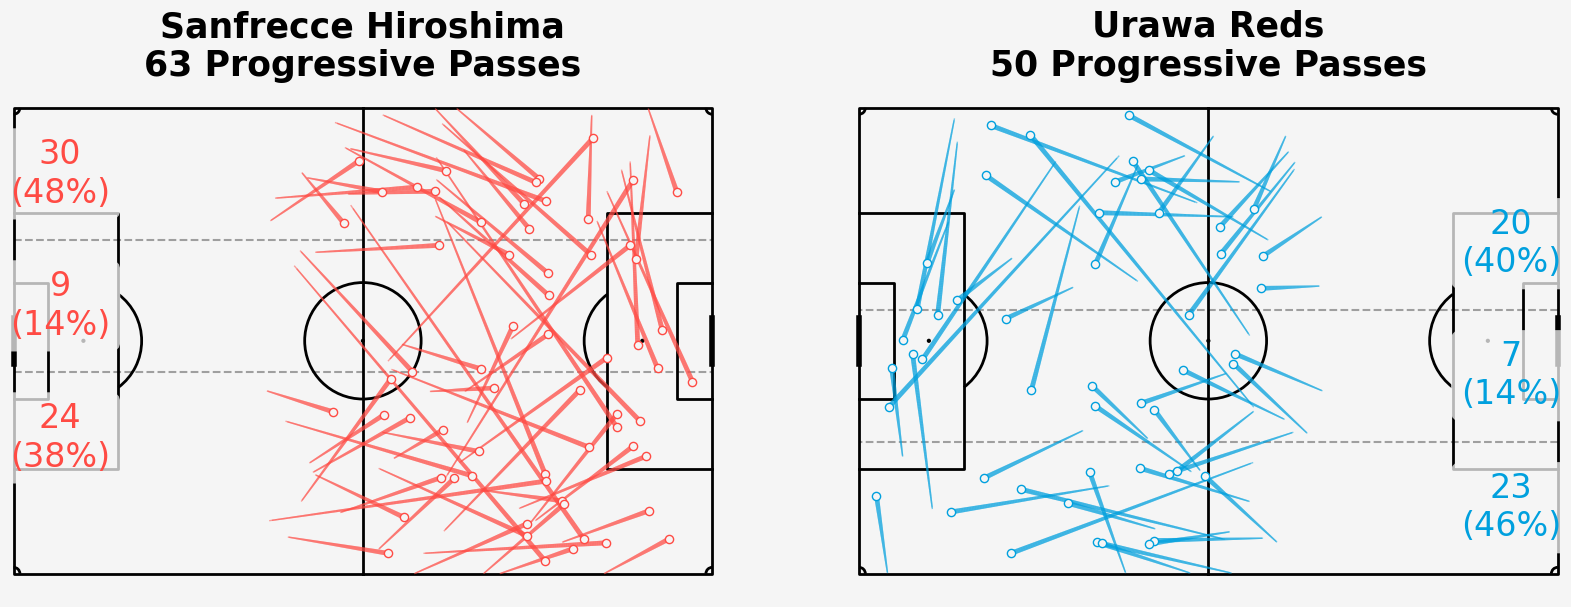

In [ ]:
def draw_progressive_pass_map(ax, team_name, col):
    dfpro = df[(df['team_name']==team_name) & (df['prog_pass']>=9.25) & (~df['play_pattern_name'].astype(str).str.contains('From Corner|From Goal Kick', case=False, na=False)) & 
    (df['x']>=40) & (df['pass_outcome_name']=='1')]
    # df_pen = df[(df['teamName']==team_name) & (df['type']=='Pass') & (df['end_x']>=88.5) & (df['end_y']>=13.6) & (df['end_y']<=54.4) &
    #             ~((df['x']>=88.5) & (df['y']>=13.6) & (df['y']<=54.6))]
    pitch = Pitch(pitch_type='statsbomb', pitch_color=bg_color, line_color=line_color, linewidth=2,
                          corner_arcs=True)
    pitch.draw(ax=ax)
    ax.set_xlim(-0.5, 120.5)
    # ax.set_ylim(-0.5, 68.5)

    if team_name == ateamName:
        ax.invert_xaxis()
        ax.invert_yaxis()

    pro_count = len(dfpro)

    # calculating the counts
    left_pro = len(dfpro[dfpro['y']>=54.33])
    mid_pro = len(dfpro[(dfpro['y']>=30.67) & (dfpro['y']<54.33)])
    right_pro = len(dfpro[(dfpro['y']>=0) & (dfpro['y']<30.67)])
    left_percentage = round((left_pro/pro_count)*100)
    mid_percentage = round((mid_pro/pro_count)*100)
    right_percentage = round((right_pro/pro_count)*100)

    ax.hlines(22.67, xmin=0, xmax=120, colors=line_color, linestyle='dashed', alpha=0.35)
    ax.hlines(45.33, xmin=0, xmax=120, colors=line_color, linestyle='dashed', alpha=0.35)

    # showing the texts in the pitch
    bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="None", facecolor=bg_color, alpha=0.75)
    if col == hcol:
        ax.text(8, 11.335, f'{right_pro}\n({right_percentage}%)', color=hcol, fontsize=24, va='center', ha='center', bbox=bbox_props)
        ax.text(8, 34, f'{mid_pro}\n({mid_percentage}%)', color=hcol, fontsize=24, va='center', ha='center', bbox=bbox_props)
        ax.text(8, 56.675, f'{left_pro}\n({left_percentage}%)', color=hcol, fontsize=24, va='center', ha='center', bbox=bbox_props)
    else:
        ax.text(8, 11.335, f'{right_pro}\n({right_percentage}%)', color=acol, fontsize=24, va='center', ha='center', bbox=bbox_props)
        ax.text(8, 34, f'{mid_pro}\n({mid_percentage}%)', color=acol, fontsize=24, va='center', ha='center', bbox=bbox_props)
        ax.text(8, 56.675, f'{left_pro}\n({left_percentage}%)', color=acol, fontsize=24, va='center', ha='center', bbox=bbox_props)

    # plotting the passes
    pro_pass = pitch.lines(dfpro.Shoter_x, dfpro.Shoter_y, dfpro.end_x, dfpro.end_y, lw=3.5, comet=True, color=col, ax=ax, alpha=0.5)
    # plotting some scatters at the end of each pass
    pro_pass_end = pitch.scatter(dfpro.end_x, dfpro.end_y, s=35, edgecolor=col, linewidth=1, color=bg_color, zorder=2, ax=ax)

    counttext = f"{pro_count} Progressive Passes"

    # Heading and other texts
    if col == hcol:
        ax.set_title(f"{hteamName}\n{counttext}", color=line_color, fontsize=25, fontweight='bold')
    else:
        ax.set_title(f"{ateamName}\n{counttext}", color=line_color, fontsize=25, fontweight='bold')

    return {
        'Team_Name': team_name,
        'Total_Progressive_Passes': pro_count,
        'Progressive_Passes_From_Left': left_pro,
        'Progressive_Passes_From_Center': mid_pro,
        'Progressive_Passes_From_Right': right_pro
    }

fig,axs=plt.subplots(1,2, figsize=(20,10), facecolor=bg_color)
Progressvie_Passes_Stats_home = draw_progressive_pass_map(axs[0], hteamName, hcol)
Progressvie_Passes_Stats_away = draw_progressive_pass_map(axs[1], ateamName, acol)
Progressvie_Passes_Stats_list = []
Progressvie_Passes_Stats_list.append(Progressvie_Passes_Stats_home)
Progressvie_Passes_Stats_list.append(Progressvie_Passes_Stats_away)
Progressvie_Passes_Stats_df = pd.DataFrame(Progressvie_Passes_Stats_list)

In [14]:
Progressvie_Passes_Stats_df

,Team_Name,Total_Progressive_Passes,Progressive_Passes_From_Left,Progressive_Passes_From_Center,Progressive_Passes_From_Right
0,Sanfrecce Hiroshima,63,24,9,30
1,Urawa Reds,50,20,7,23


Progressive Carry

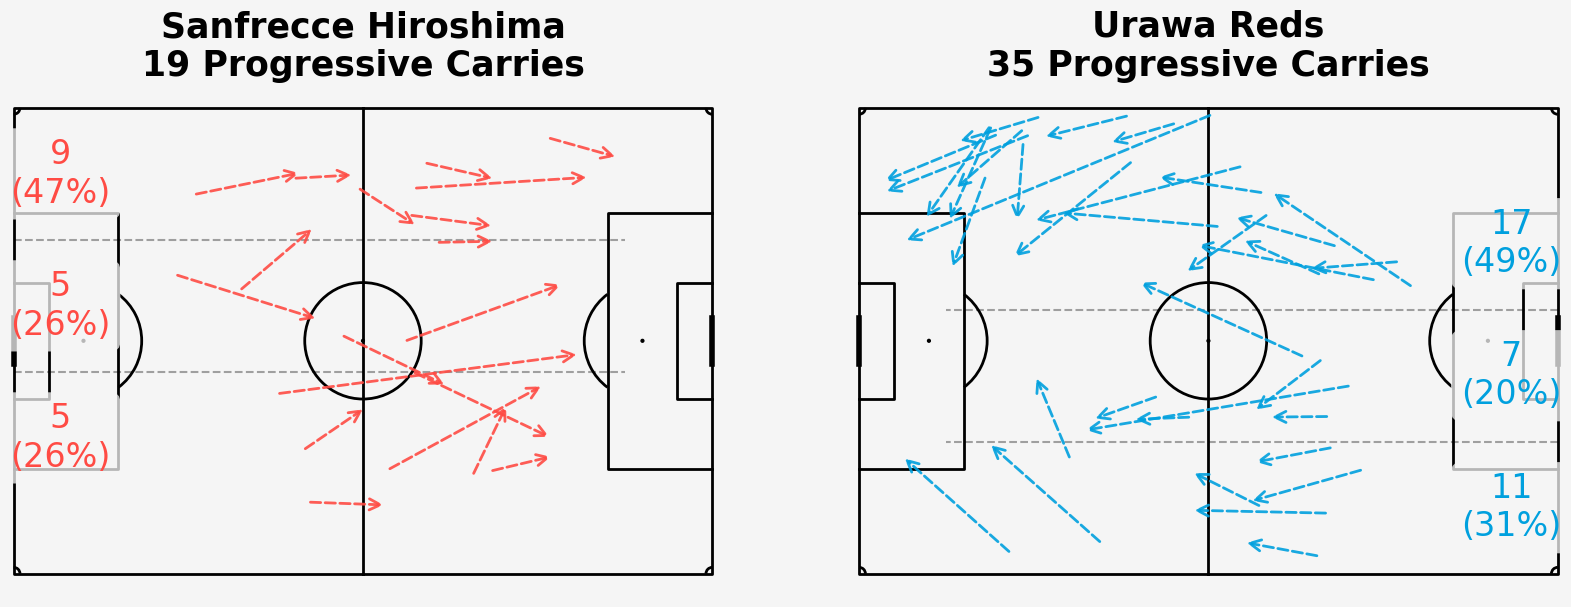

In [15]:
def draw_progressive_carry_map(ax, team_name, col):
    dfpro = df[(df['team_name']==team_name) & (df['prog_carry']>=9.25) & (df['carry_end_x']>=40)]
    # df_pen = df[(df['team_name']==team_name) & (df['type_name']=='Pass') & (df['end_x']>=88.5) & (df['end_y']>=13.6) & (df['end_y']<=54.4) &
    #             ~((df['x']>=88.5) & (df['y']>=13.6) & (df['y']<=54.6))]
    pitch = Pitch(pitch_type='statsbomb', pitch_color=bg_color, line_color=line_color, linewidth=2,
                          corner_arcs=True)
    pitch.draw(ax=ax)
    ax.set_xlim(-0.5, 120.5)
    # ax.set_ylim(-5, 68.5)

    if team_name == ateamName:
        ax.invert_xaxis()
        ax.invert_yaxis()

    pro_count = len(dfpro)

    # calculating the counts
    left_pro = len(dfpro[dfpro['y']>=54.33])
    mid_pro = len(dfpro[(dfpro['y']>=30.67) & (dfpro['y']<54.33)])
    right_pro = len(dfpro[(dfpro['y']>=0) & (dfpro['y']<30.67)])
    left_percentage = round((left_pro/pro_count)*100)
    mid_percentage = round((mid_pro/pro_count)*100)
    right_percentage = round((right_pro/pro_count)*100)

    ax.hlines(22.67, xmin=0, xmax=105, colors=line_color, linestyle='dashed', alpha=0.35)
    ax.hlines(45.33, xmin=0, xmax=105, colors=line_color, linestyle='dashed', alpha=0.35)

    # showing the texts in the pitch
    bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="None", facecolor=bg_color, alpha=0.75)
    if col == hcol:
        ax.text(8, 11.335, f'{right_pro}\n({right_percentage}%)', color=hcol, fontsize=24, va='center', ha='center', bbox=bbox_props)
        ax.text(8, 34, f'{mid_pro}\n({mid_percentage}%)', color=hcol, fontsize=24, va='center', ha='center', bbox=bbox_props)
        ax.text(8, 56.675, f'{left_pro}\n({left_percentage}%)', color=hcol, fontsize=24, va='center', ha='center', bbox=bbox_props)
    else:
        ax.text(8, 11.335, f'{right_pro}\n({right_percentage}%)', color=acol, fontsize=24, va='center', ha='center', bbox=bbox_props)
        ax.text(8, 34, f'{mid_pro}\n({mid_percentage}%)', color=acol, fontsize=24, va='center', ha='center', bbox=bbox_props)
        ax.text(8, 56.675, f'{left_pro}\n({left_percentage}%)', color=acol, fontsize=24, va='center', ha='center', bbox=bbox_props)

    # plotting the carries
    for index, row in dfpro.iterrows():
        arrow = patches.FancyArrowPatch((row['x'], row['y']), (row['carry_end_x'], row['carry_end_y']), arrowstyle='->', color=col, zorder=4, mutation_scale=20, 
                                        alpha=0.9, linewidth=2, linestyle='--')
        ax.add_patch(arrow)

    counttext = f"{pro_count} Progressive Carries"

    # Heading and other texts
    if col == hcol:
        ax.set_title(f"{hteamName}\n{counttext}", color=line_color, fontsize=25, fontweight='bold')
    else:
        ax.set_title(f"{ateamName}\n{counttext}", color=line_color, fontsize=25, fontweight='bold')

    return {
        'Team_Name': team_name,
        'Total_Progressive_Carries': pro_count,
        'Progressive_Carries_From_Left': left_pro,
        'Progressive_Carries_From_Center': mid_pro,
        'Progressive_Carries_From_Right': right_pro
    }

fig,axs=plt.subplots(1,2, figsize=(20,10), facecolor=bg_color)
Progressvie_Carries_Stats_home = draw_progressive_carry_map(axs[0], hteamName, hcol)
Progressvie_Carries_Stats_away = draw_progressive_carry_map(axs[1], ateamName, acol)
Progressvie_Carries_Stats_list = []
Progressvie_Carries_Stats_list.append(Progressvie_Carries_Stats_home)
Progressvie_Carries_Stats_list.append(Progressvie_Carries_Stats_away)
Progressvie_Carries_Stats_df = pd.DataFrame(Progressvie_Carries_Stats_list)

In [16]:
Progressvie_Carries_Stats_df

,Team_Name,Total_Progressive_Carries,Progressive_Carries_From_Left,Progressive_Carries_From_Center,Progressive_Carries_From_Right
0,Sanfrecce Hiroshima,19,5,5,9
1,Urawa Reds,35,17,7,11


ShotMap

Away team shots:
    index  period     timestamp  minute  second  possession  duration  type_id  \
1    277       1  00:05:15.543       5      15          14    0.3581       16   
2    281       1  00:05:53.321       5      53          15    0.3891       16   
3    317       1  00:06:28.009       6      28          15    1.5053       16   
7   1013       1  00:24:23.385      24      23          54    0.0585       16   
8   1037       1  00:25:23.449      25      23          57    0.6169       16   

  type_name  possession_team_id possession_team_name  play_pattern_id  \
1      Shot                1882           Urawa Reds                3   
2      Shot                1882           Urawa Reds                2   
3      Shot                1882           Urawa Reds                2   
7      Shot                1882           Urawa Reds                8   
8      Shot                1882           Urawa Reds                2   

  play_pattern_name  team_id   team_name  tactics_format

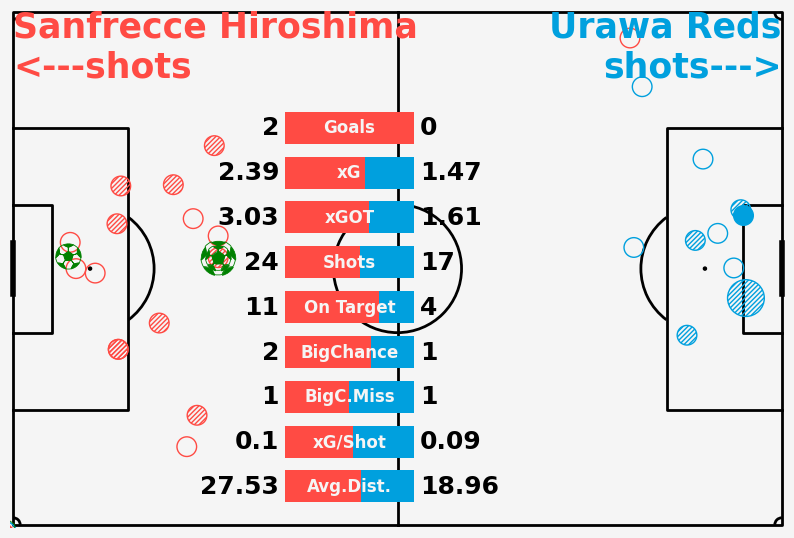

In [56]:

# Step 1: Select shot events + own goals
# Step 1: Filter all shot events + own goals
shots_df = df[
    (df['type_name'] == 'Shot') |
    (df['type_name'].astype(str).str.contains('Own Goal Against', na=False)) |
    (df['type_name'].astype(str).str.contains('Own Goal For', na=False))
]

# Step 2: Filter only meaningful outcomes
mask4 = shots_df['shot_outcome_name'].isin(['Goal', 'Off T', 'Saved', 'Blocked', 'Post'])
Shotsdf = shots_df[mask4].reset_index(drop=True)

# Step 3: Split by team
hShotsdf = Shotsdf[Shotsdf['team_name'] == hteamName]
aShotsdf = Shotsdf[Shotsdf['team_name'] == ateamName]

# Step 4: Filter by outcome
hSavedf = hShotsdf[hShotsdf['shot_outcome_name'] == 'Saved']
aSavedf = aShotsdf[aShotsdf['shot_outcome_name'] == 'Saved']

# Step 5: Own goals only
hogdf = hShotsdf[hShotsdf['type_name'].astype(str).str.contains('Own Goal For', na=False)]
aogdf = aShotsdf[aShotsdf['type_name'].astype(str).str.contains('Own Goal For', na=False)]

# Step 6: Preview
print("Away team shots:\n", aShotsdf.head())

hgoal_count = len(hShotsdf[(hShotsdf['team_name']==hteamName) & (hShotsdf['shot_outcome_name']=='Goal')])
agoal_count = len(aShotsdf[(aShotsdf['team_name']==ateamName) & (aShotsdf['shot_outcome_name']=='Goal')])
hxg = hShotsdf['shot_statsbomb_xg'].sum().round(2)
hxgot = hShotsdf['shot_gk_save_difficulty_xg'].sum().round(2)
axgot = aShotsdf['shot_gk_save_difficulty_xg'].sum().round(2)
axg = aShotsdf['shot_statsbomb_xg'].sum().round(2)
# Center Goal point
given_point = (120, 40)
# Calculate distances
home_shot_distances = np.sqrt((hShotsdf['Shoter_x'] - given_point[0])**2 + (hShotsdf['Shoter_y'] - given_point[1])**2)
home_average_shot_distance = round(home_shot_distances.mean(),2)
away_shot_distances = np.sqrt((aShotsdf['Shoter_x'] - given_point[0])**2 + (aShotsdf['Shoter_y'] - given_point[1])**2)
away_average_shot_distance = round(away_shot_distances.mean(),2)

def plot_shotmap(ax):
    pitch = Pitch(pitch_type='statsbomb', corner_arcs=True, pitch_color=bg_color, linewidth=2, line_color=line_color)
    pitch.draw(ax=ax)
    ax.set_ylim(-0.5, 80.5)
    ax.set_xlim(-0.5, 120.5)

    # shooting stats
    hTotalShots = len(hShotsdf)
    aTotalShots = len(aShotsdf)
    hShotsOnT = len(hSavedf) + hgoal_count
    aShotsOnT = len(aSavedf) + agoal_count
    hxGpSh = round(hxg / hTotalShots, 2)
    axGpSh = round(axg / aTotalShots, 2)

    # --- HOME TEAM ---
    hGoalData = hShotsdf[(hShotsdf['shot_outcome_name'] == 'Goal')]
    hPostData = hShotsdf[(hShotsdf['shot_outcome_name'] == 'Post')]
    hSaveData = hShotsdf[(hShotsdf['shot_outcome_name'] == 'Saved')]
    hMissData = hShotsdf[(hShotsdf['shot_outcome_name'] == 'Off T')]

    Big_C_hGoalData = hShotsdf[
    (hShotsdf['shot_outcome_name'] == 'Goal') &
    (hShotsdf['shot_statsbomb_xg'] >= 0.2)
      ]
    Big_C_hPostData = hShotsdf[
         (hShotsdf['shot_outcome_name'] == 'Post') &
         (hShotsdf['shot_statsbomb_xg'] >= 0.2)
      ]
    Big_C_hSaveData = hShotsdf[
         (hShotsdf['shot_outcome_name'] == 'Saved') &
         (hShotsdf['shot_statsbomb_xg'] >= 0.2)
      ]
    Big_C_hMissData = hShotsdf[
         (hShotsdf['shot_outcome_name'] == 'Off T') &
         (hShotsdf['shot_statsbomb_xg'] >= 0.2)
      ]

    total_bigC_home = len(Big_C_hGoalData) + len(Big_C_hPostData) + len(Big_C_hSaveData) + len(Big_C_hMissData)
    bigC_miss_home = len(Big_C_hPostData) + len(Big_C_hSaveData) + len(Big_C_hMissData)

    # plot home team shots
    pitch.scatter((120 - hPostData.Shoter_x), (80 - hPostData.Shoter_y), s=200, edgecolors=hcol, c=hcol, marker='o', ax=ax)
    pitch.scatter((120 - hSaveData.Shoter_x), (80 - hSaveData.Shoter_y), s=200, edgecolors=hcol, c='None', hatch='///////', marker='o', ax=ax)
    pitch.scatter((120 - hMissData.Shoter_x), (80 - hMissData.Shoter_y), s=200, edgecolors=hcol, c='None', marker='o', ax=ax)
    pitch.scatter((120 - hGoalData.Shoter_x), (80 - hGoalData.Shoter_y), s=350, edgecolors='green', linewidths=0.6, c='None', marker='football', zorder=3, ax=ax)
    pitch.scatter((120 - hogdf.Shoter_x), (80 - hogdf.Shoter_y), s=350, edgecolors='orange', linewidths=0.6, c='None', marker='football', zorder=3, ax=ax)

    pitch.scatter((120 - Big_C_hPostData.Shoter_x), (80 - Big_C_hPostData.Shoter_y), s=500, edgecolors=hcol, c=hcol, marker='o', ax=ax)
    pitch.scatter((120 - Big_C_hSaveData.Shoter_x), (80 - Big_C_hSaveData.Shoter_y), s=500, edgecolors=hcol, c='None', hatch='///////', marker='o', ax=ax)
    pitch.scatter((120 - Big_C_hMissData.Shoter_x), (80 - Big_C_hMissData.Shoter_y), s=500, edgecolors=hcol, c='None', marker='o', ax=ax)
    pitch.scatter((120 - Big_C_hGoalData.Shoter_x), (80 - Big_C_hGoalData.Shoter_y), s=650, edgecolors='green', linewidths=0.6, c='None', marker='football', ax=ax)

    # --- AWAY TEAM ---
    # Non-Big Chances (lower xG)
    aGoalData = aShotsdf[
        (aShotsdf['shot_outcome_name'] == 'Goal') &
        (aShotsdf['shot_statsbomb_xg'] < 0.3)
    ]

    aPostData = aShotsdf[
        (aShotsdf['shot_outcome_name'] == 'Post') &
        (aShotsdf['shot_statsbomb_xg'] < 0.3)
    ]

    aSaveData = aShotsdf[
        (aShotsdf['shot_outcome_name'] == 'Saved') &
        (aShotsdf['shot_statsbomb_xg'] < 0.3)
    ]

    aMissData = aShotsdf[
        (aShotsdf['shot_outcome_name'] == 'Off T') &
        (aShotsdf['shot_statsbomb_xg'] < 0.3)
    ]

# Big Chances (using xG threshold)
    Big_C_aGoalData = aShotsdf[
        (aShotsdf['shot_outcome_name'] == 'Goal') &
        (aShotsdf['shot_statsbomb_xg'] >= 0.3)
    ]

    Big_C_aPostData = aShotsdf[
        (aShotsdf['shot_outcome_name'] == 'Post') &
        (aShotsdf['shot_statsbomb_xg'] >= 0.3)
    ]

    Big_C_aSaveData = aShotsdf[
        (aShotsdf['shot_outcome_name'] == 'Saved') &
        (aShotsdf['shot_statsbomb_xg'] >= 0.3)
    ]

    Big_C_aMissData = aShotsdf[
        (aShotsdf['shot_outcome_name'] == 'Off T') &
        (aShotsdf['shot_statsbomb_xg'] >= 0.3)
    ]

# Totals
    total_bigC_away = (
        len(Big_C_aGoalData) +
        len(Big_C_aPostData) +
        len(Big_C_aSaveData) +
        len(Big_C_aMissData)
    )

    bigC_miss_away = (
        len(Big_C_aPostData) +
        len(Big_C_aSaveData) +
        len(Big_C_aMissData)
    )


    # normal shots scatter of away team
    pitch.scatter(aPostData.Shoter_x, aPostData.Shoter_y, s=200, edgecolors=acol, c=acol, marker='o', ax=ax)
    pitch.scatter(aSaveData.Shoter_x, aSaveData.Shoter_y, s=200, edgecolors=acol, c='None', hatch='///////', marker='o', ax=ax)
    pitch.scatter(aMissData.Shoter_x, aMissData.Shoter_y, s=200, edgecolors=acol, c='None', marker='o', ax=ax)
    pitch.scatter(aGoalData.Shoter_x, aGoalData.Shoter_y, s=350, edgecolors='green', linewidths=0.6, c='None', marker='football', zorder=3, ax=ax)
    pitch.scatter(aogdf.Shoter_x, aogdf.Shoter_y, s=350, edgecolors='orange', linewidths=0.6, c='None', marker='football', zorder=3, ax=ax)

    pitch.scatter(Big_C_aPostData.Shoter_x, Big_C_aPostData.Shoter_y, s=700, edgecolors=acol, c=acol, marker='o', ax=ax)
    pitch.scatter(Big_C_aSaveData.Shoter_x, Big_C_aSaveData.Shoter_y, s=700, edgecolors=acol, c='None', hatch='///////', marker='o', ax=ax)
    pitch.scatter(Big_C_aMissData.Shoter_x, Big_C_aMissData.Shoter_y, s=700, edgecolors=acol, c='None', marker='o', ax=ax)
    pitch.scatter(Big_C_aGoalData.Shoter_x, Big_C_aGoalData.Shoter_y, s=850, edgecolors='green', linewidths=0.6, c='None', marker='football', ax=ax)

    # --- NORMALIZED STATS BAR ---
    if hgoal_count + agoal_count == 0:
        hgoal = agoal = 10
    else:
        hgoal = (hgoal_count / (hgoal_count + agoal_count)) * 20
        agoal = (agoal_count / (hgoal_count + agoal_count)) * 20

    if total_bigC_home + total_bigC_away == 0:
        total_bigC_home_n = total_bigC_away_n = 10
    else:
        total_bigC_home_n = (total_bigC_home / (total_bigC_home + total_bigC_away)) * 20
        total_bigC_away_n = (total_bigC_away / (total_bigC_home + total_bigC_away)) * 20

    if bigC_miss_home + bigC_miss_away == 0:
        bigC_miss_home_n = bigC_miss_away_n = 10
    else:
        bigC_miss_home_n = (bigC_miss_home / (bigC_miss_home + bigC_miss_away)) * 20
        bigC_miss_away_n = (bigC_miss_away / (bigC_miss_home + bigC_miss_away)) * 20

    if hShotsOnT + aShotsOnT == 0:
        hShotsOnT_n = aShotsOnT_n = 10
    else:
        hShotsOnT_n = (hShotsOnT / (hShotsOnT + aShotsOnT)) * 20
        aShotsOnT_n = (aShotsOnT / (hShotsOnT + aShotsOnT)) * 20

    if hxgot + axgot == 0:
        hxgot_n = axgot_n = 10
    else:
        hxgot_n = (hxgot / (hxgot + axgot)) * 20
        axgot_n = (axgot / (hxgot + axgot)) * 20

    shooting_stats_title = [62, 62-(1*7), 62-(2*7), 62-(3*7), 62-(4*7), 62-(5*7), 62-(6*7), 62-(7*7), 62-(8*7)]
    shooting_stats_home = [hgoal_count, hxg, hxgot, hTotalShots, hShotsOnT, hxGpSh, total_bigC_home, bigC_miss_home, home_average_shot_distance]
    shooting_stats_away = [agoal_count, axg, axgot, aTotalShots, aShotsOnT, axGpSh, total_bigC_away, bigC_miss_away, away_average_shot_distance]

    shooting_stats_normalized_home = [
        hgoal,
        (hxg / (hxg + axg)) * 20,
        hxgot_n,
        (hTotalShots / (hTotalShots + aTotalShots)) * 20,
        hShotsOnT_n,
        total_bigC_home_n,
        bigC_miss_home_n,
        (hxGpSh / (hxGpSh + axGpSh)) * 20,
        (home_average_shot_distance / (home_average_shot_distance + away_average_shot_distance)) * 20
    ]

    shooting_stats_normalized_away = [
        agoal,
        (axg / (hxg + axg)) * 20,
        axgot_n,
        (aTotalShots / (hTotalShots + aTotalShots)) * 20,
        aShotsOnT_n,
        total_bigC_away_n,
        bigC_miss_away_n,
        (axGpSh / (hxGpSh + axGpSh)) * 20,
        (away_average_shot_distance / (home_average_shot_distance + away_average_shot_distance)) * 20
    ]

    start_x = 42.5
    start_x_for_away = [x + 42.5 for x in shooting_stats_normalized_home]

    ax.barh(shooting_stats_title, shooting_stats_normalized_home, height=5, color=hcol, left=start_x)
    ax.barh(shooting_stats_title, shooting_stats_normalized_away, height=5, left=start_x_for_away, color=acol)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)
    ax.set_xticks([])
    ax.set_yticks([])

    # plotting the texts
    ax.text(52.5, 62, "Goals", color=bg_color, fontsize=12, ha='center', va='center', fontweight='bold')
    ax.text(52.5, 62-(1*7), "xG", color=bg_color, fontsize=12, ha='center', va='center', fontweight='bold')
    ax.text(52.5, 62-(2*7), "xGOT", color=bg_color, fontsize=12, ha='center', va='center', fontweight='bold')
    ax.text(52.5, 62-(3*7), "Shots", color=bg_color, fontsize=12, ha='center', va='center', fontweight='bold')
    ax.text(52.5, 62-(4*7), "On Target", color=bg_color, fontsize=12, ha='center', va='center', fontweight='bold')
    ax.text(52.5, 62-(5*7), "BigChance", color=bg_color, fontsize=12, ha='center', va='center', fontweight='bold')
    ax.text(52.5, 62-(6*7), "BigC.Miss", color=bg_color, fontsize=12, ha='center', va='center', fontweight='bold')
    ax.text(52.5, 62-(7*7), "xG/Shot", color=bg_color, fontsize=12, ha='center', va='center', fontweight='bold')
    ax.text(52.5, 62-(8*7), "Avg.Dist.", color=bg_color, fontsize=12, ha='center', va='center', fontweight='bold')

    ax.text(41.5, 62, f"{hgoal_count}", color=line_color, fontsize=18, ha='right', va='center', fontweight='bold')
    ax.text(41.5, 62-(1*7), f"{hxg}", color=line_color, fontsize=18, ha='right', va='center', fontweight='bold')
    ax.text(41.5, 62-(2*7), f"{hxgot}", color=line_color, fontsize=18, ha='right', va='center', fontweight='bold')
    ax.text(41.5, 62-(3*7), f"{hTotalShots}", color=line_color, fontsize=18, ha='right', va='center', fontweight='bold')
    ax.text(41.5, 62-(4*7), f"{hShotsOnT}", color=line_color, fontsize=18, ha='right', va='center', fontweight='bold')
    ax.text(41.5, 62-(5*7), f"{total_bigC_home}", color=line_color, fontsize=18, ha='right', va='center', fontweight='bold')
    ax.text(41.5, 62-(6*7), f"{bigC_miss_home}", color=line_color, fontsize=18, ha='right', va='center', fontweight='bold')
    ax.text(41.5, 62-(7*7), f"{hxGpSh}", color=line_color, fontsize=18, ha='right', va='center', fontweight='bold')
    ax.text(41.5, 62-(8*7), f"{home_average_shot_distance}", color=line_color, fontsize=18, ha='right', va='center', fontweight='bold')

    ax.text(63.5, 62, f"{agoal_count}", color=line_color, fontsize=18, ha='left', va='center', fontweight='bold')
    ax.text(63.5, 62-(1*7), f"{axg}", color=line_color, fontsize=18, ha='left', va='center', fontweight='bold')
    ax.text(63.5, 62-(2*7), f"{axgot}", color=line_color, fontsize=18, ha='left', va='center', fontweight='bold')
    ax.text(63.5, 62-(3*7), f"{aTotalShots}", color=line_color, fontsize=18, ha='left', va='center', fontweight='bold')
    ax.text(63.5, 62-(4*7), f"{aShotsOnT}", color=line_color, fontsize=18, ha='left', va='center', fontweight='bold')
    ax.text(63.5, 62-(5*7), f"{total_bigC_away}", color=line_color, fontsize=18, ha='left', va='center', fontweight='bold')
    ax.text(63.5, 62-(6*7), f"{bigC_miss_away}", color=line_color, fontsize=18, ha='left', va='center', fontweight='bold')
    ax.text(63.5, 62-(7*7), f"{axGpSh}", color=line_color, fontsize=18, ha='left', va='center', fontweight='bold')
    ax.text(63.5, 62-(8*7), f"{away_average_shot_distance}", color=line_color, fontsize=18, ha='left', va='center', fontweight='bold')

    # Heading and other texts
    ax.text(0, 70, f"{hteamName}\n<---shots", color=hcol, size=25, ha='left', fontweight='bold')
    ax.text(120, 70, f"{ateamName}\nshots--->", color=acol, size=25, ha='right', fontweight='bold')

    home_data = {
        'Team_Name': hteamName,
        'Goals_Scored': hgoal_count,
        'xG': hxg,
        'xGOT': hxgot,
        'Total_Shots': hTotalShots,
        'Shots_On_Target': hShotsOnT,
        'BigChances': total_bigC_home,
        'BigChances_Missed': bigC_miss_home,
        'xG_per_Shot': hxGpSh,
        'Average_Shot_Distance': home_average_shot_distance
    }
    
    away_data = {
        'Team_Name': ateamName,
        'Goals_Scored': agoal_count,
        'xG': axg,
        'xGOT': axgot,
        'Total_Shots': aTotalShots,
        'Shots_On_Target': aShotsOnT,
        'BigChances': total_bigC_away,
        'BigChances_Missed': bigC_miss_away,
        'xG_per_Shot': axGpSh,
        'Average_Shot_Distance': away_average_shot_distance
    }
    
    return [home_data, away_data]

fig,ax=plt.subplots(figsize=(10,10), facecolor=bg_color)
shooting_stats = plot_shotmap(ax)
shooting_stats_df = pd.DataFrame(shooting_stats)

In [57]:
shooting_stats_df

,Team_Name,Goals_Scored,xG,xGOT,Total_Shots,Shots_On_Target,BigChances,BigChances_Missed,xG_per_Shot,Average_Shot_Distance
0,Sanfrecce Hiroshima,2,2.39,3.03,24,11,2,1,0.10,27.53
1,Urawa Reds,0,1.47,1.61,17,4,1,1,0.09,18.96


GoalPost

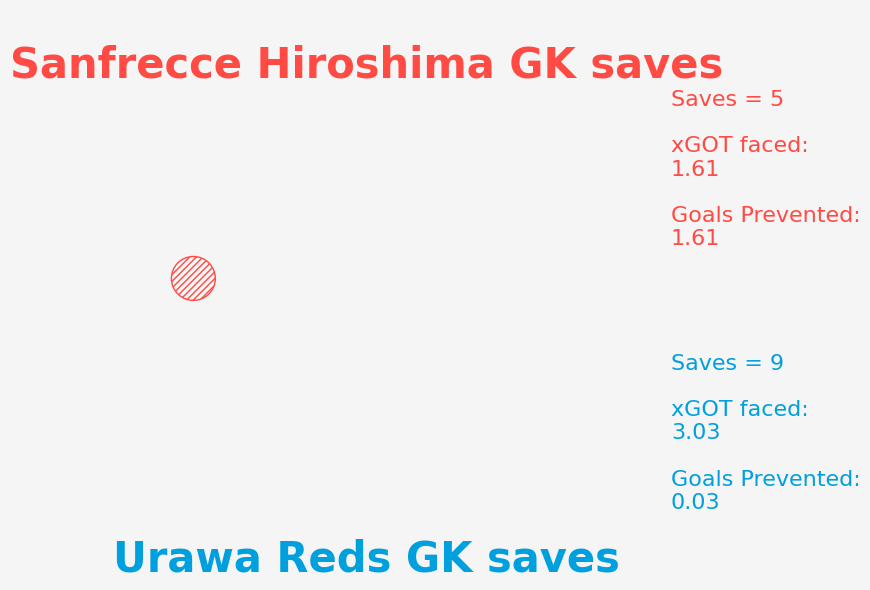

In [169]:
def plot_goalPost(ax):
    hShotsdf = Shotsdf[Shotsdf['team_name'] == hteamName].copy()
    aShotsdf = Shotsdf[Shotsdf['team_name'] == ateamName].copy()

    # Convert to goal post scale
    hShotsdf['shot_end_z'] = hShotsdf['shot_end_z'] * 0.75
    aShotsdf['shot_end_z'] = (aShotsdf['shot_end_z'] * 0.75) + 38

    hShotsdf['shot_end_y'] = ((37.66 - hShotsdf['shot_end_y']) * 12.295) + 7.5
    aShotsdf['shot_end_y'] = ((37.66 - aShotsdf['shot_end_y']) * 12.295) + 7.5

    pitch = Pitch(pitch_type='statsbomb', corner_arcs=True, pitch_color=bg_color, line_color=bg_color, linewidth=2)
    pitch.draw(ax=ax)
    ax.set_ylim(-0.5, 80.5)
    ax.set_xlim(-0.5, 120.5)

    # Define required filters
    hSavedf = hShotsdf[hShotsdf['shot_outcome_name'] == 'Saved']
    hGoaldf = hShotsdf[hShotsdf['shot_outcome_name'] == 'Goal']
    aSavedf = aShotsdf[aShotsdf['shot_outcome_name'] == 'Saved']
    aGoaldf = aShotsdf[aShotsdf['shot_outcome_name'] == 'Goal']

    hSavedf_bc = hSavedf[hSavedf['shot_statsbomb_xg'] >= 0.3]
    hGoaldf_bc = hGoaldf[hGoaldf['shot_statsbomb_xg'] >= 0.3]
    hPostdf_bc = hShotsdf[(hShotsdf['shot_outcome_name'] == 'Post') & (hShotsdf['shot_statsbomb_xg'] >= 0.2)]

    aSavedf_bc = aSavedf[aSavedf['shot_statsbomb_xg'] >= 0.3]
    aGoaldf_bc = aGoaldf[aGoaldf['shot_statsbomb_xg'] >= 0.3]
    aPostdf_bc = aShotsdf[(aShotsdf['shot_outcome_name'] == 'Post') & (aShotsdf['shot_statsbomb_xg'] >= 0.2)]

    # Scatter plots
    pitch.scatter(hSavedf_bc.shot_end_y, hSavedf_bc.shot_end_z, marker='o', c=bg_color, zorder=3,
                  edgecolor=acol, hatch='/////', s=1000, ax=ax)
    pitch.scatter(hGoaldf_bc.shot_end_y, hGoaldf_bc.shot_end_z, marker='football', c=bg_color, zorder=3,
                  edgecolors='green', s=1000, ax=ax)
    pitch.scatter(hPostdf_bc.shot_end_y, hPostdf_bc.shot_end_z, marker='o', c=bg_color, zorder=3,
                  edgecolors='orange', hatch='/////', s=1000, ax=ax)

    pitch.scatter(aSavedf_bc.shot_end_y, aSavedf_bc.shot_end_z, marker='o', c=bg_color, zorder=3,
                  edgecolor=hcol, hatch='/////', s=1000, ax=ax)
    pitch.scatter(aGoaldf_bc.shot_end_y, aGoaldf_bc.shot_end_z, marker='football', c=bg_color, zorder=3,
                  edgecolors='green', s=1000, ax=ax)
    pitch.scatter(aPostdf_bc.shot_end_y, aPostdf_bc.shot_end_z, marker='o', c=bg_color, zorder=3,
                  edgecolors='orange', hatch='/////', s=1000, ax=ax)

    # Add Text
    ax.text(52.5, 70, f"{hteamName} GK saves", color=hcol, fontsize=30, ha='center', fontweight='bold')
    ax.text(52.5, -2, f"{ateamName} GK saves", color=acol, fontsize=30, ha='center', va='top', fontweight='bold')

    ax.text(100, 68,
            f"Saves = {len(aSavedf) + len(aSavedf_bc)}\n\nxGOT faced:\n{axgot}\n\nGoals Prevented:\n{round(axgot - len(aGoaldf) - len(aGoaldf_bc), 2)}",
            color=hcol, fontsize=16, va='top', ha='left')

    ax.text(100, 2,
            f"Saves = {len(hSavedf) + len(hSavedf_bc)}\n\nxGOT faced:\n{hxgot}\n\nGoals Prevented:\n{round(hxgot - len(hGoaldf) - len(hGoaldf_bc), 2)}",
            color=acol, fontsize=16, va='bottom', ha='left')

    # Return Data
    home_data = {
        'Team_Name': hteamName,
        'Shots_Saved': len(hSavedf) + len(hSavedf_bc),
        'Big_Chance_Saved': len(hSavedf_bc),
        'Goals_Prevented': round(hxgot - len(hGoaldf) - len(hGoaldf_bc), 2)
    }

    away_data = {
        'Team_Name': ateamName,
        'Shots_Saved': len(aSavedf) + len(aSavedf_bc),
        'Big_Chance_Saved': len(aSavedf_bc),
        'Goals_Prevented': round(axgot - len(aGoaldf) - len(aGoaldf_bc), 2)
    }

    return [home_data, away_data]


# Call the function and store the DataFrame
fig, ax = plt.subplots(figsize=(10, 10), facecolor=bg_color)
goalkeeper_stats = plot_goalPost(ax)
goalkeeper_stats_df = pd.DataFrame(goalkeeper_stats)


In [170]:
goalkeeper_stats_df

,Team_Name,Shots_Saved,Big_Chance_Saved,Goals_Prevented
0,Sanfrecce Hiroshima,9,0,0.03
1,Urawa Reds,5,1,1.61


Match Momentum

In [62]:
# Filter rows with xT > 0 for both teams
home_xT_df = df[(df['team_name'] == hteamName) ]
away_xT_df = df[(df['team_name'] == ateamName)]

# Sum xT per team
home_xT_sum = home_xT_df['xT'].sum()
away_xT_sum = away_xT_df['xT'].sum()

# Create summary DataFrame
xT_stats_df = pd.DataFrame({
    'Team_Name': [hteamName, ateamName],
    'Total_xT': [home_xT_sum, away_xT_sum]
})

# Preview
print(xT_stats_df)


             Team_Name  Total_xT
0  Sanfrecce Hiroshima  3.810530
1           Urawa Reds  3.273055


Match Stats

C:\Users\lahd2\AppData\Local\Temp\ipykernel_31424\2785102144.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  home_goalkick['pass_length'] = home_goalkick['pass_length'].astype(float)
C:\Users\lahd2\AppData\Local\Temp\ipykernel_31424\2785102144.py:248: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  away_goalkick['pass_length'] = away_goalkick['pass_length'].astype(float)


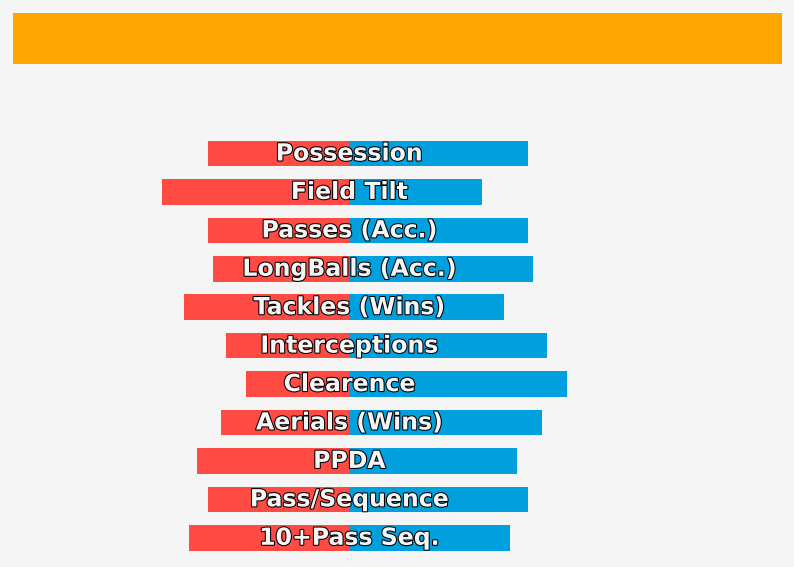

In [89]:
# -------------------- PASSING STATS --------------------
hpossdf = df[(df['team_name']==hteamName) & (df['type_name']=='Pass')]
apossdf = df[(df['team_name']==ateamName) & (df['type_name']=='Pass')]
hposs = round((len(hpossdf)/(len(hpossdf)+len(apossdf)))*100,2)
aposs = round((len(apossdf)/(len(hpossdf)+len(apossdf)))*100,2)
hftdf = df[
    (df['team_name'] == hteamName) &
    (df['type_name'].isin(['Pass', 'Ball Receipt'])) &
    (df['pass_outcome_name'] == "1") &
    (df['x'] >= 80)
]

aftdf = df[
    (df['team_name'] == ateamName) &
    (df['type_name'].isin(['Pass', 'Ball Receipt'])) &
    (df['pass_outcome_name'] == "1") &
    (df['x'] >= 80)
]

hft = round((len(hftdf)/(len(hftdf)+len(aftdf)))*100, 2)
aft = round((len(aftdf)/(len(hftdf)+len(aftdf)))*100, 2)
dfpass_h = df[(df['type_name'] == 'Pass') & (df['team_name'] == hteamName)]
acc_pass_h = dfpass_h[dfpass_h['pass_outcome_name'] == "1"]
accurate_pass_perc_h = round((len(acc_pass_h) / len(dfpass_h)) * 100, 2) if len(dfpass_h) != 0 else 0

pro_pass_h = acc_pass_h[(acc_pass_h['prog_pass'] >= 9.25) & (acc_pass_h['x'] >= 41) & 
    (~acc_pass_h['play_pattern_name'].astype(str).str.contains('From Corner|From Goal Kick', case=False, na=False))]

Thr_ball_h = dfpass_h[dfpass_h['pass_technique_name'].astype(str).str.contains('Throughball', case=False, na=False)]
Thr_ball_acc_h = Thr_ball_h[Thr_ball_h['pass_outcome_name'] == "1"]

Lng_ball_h = dfpass_h[dfpass_h['pass_pass_cluster_label'].astype(str).str.contains('Long', case=False, na=False)]
Lng_ball_acc_h = Lng_ball_h[Lng_ball_h['pass_outcome_name'] == "1"]

Crs_pass_h = dfpass_h[dfpass_h['pass_cross'].astype(str).str.contains('TRUE', case=False, na=False)]
Crs_pass_acc_h = Crs_pass_h[Crs_pass_h['pass_outcome_name'] == "1"]

key_pass_h = dfpass_h[dfpass_h['pass_shot_assist'].astype(str).str.contains('TRUE', case=False, na=False)]
g_assist_h = dfpass_h[dfpass_h['pass_goal_assist'].astype(str).str.contains('TRUE', case=False, na=False)]

fnl_thd_h = acc_pass_h[acc_pass_h['end_x'] >= 92.5]
pen_box_h = acc_pass_h[(acc_pass_h['end_x'] >= 102) & (acc_pass_h['end_y'].between(18.62, 62))]

frwd_pass_h = dfpass_h[dfpass_h['pass_or_carry_angle'].between(-85, 85)]
back_pass_h = dfpass_h[(dfpass_h['pass_or_carry_angle'] >= 95) | (dfpass_h['pass_or_carry_angle'] <= -95)]
side_pass_h = dfpass_h[(dfpass_h['pass_or_carry_angle'].between(-95, -85)) | (dfpass_h['pass_or_carry_angle'].between(85, 95))]

frwd_pass_acc_h = frwd_pass_h[frwd_pass_h['pass_outcome_name'] == "1"]
back_pass_acc_h = back_pass_h[back_pass_h['pass_outcome_name'] == "1"]
side_pass_acc_h = side_pass_h[side_pass_h['pass_outcome_name'] == "1"]

corners_h = dfpass_h[dfpass_h['play_pattern_name'].astype(str).str.contains('From Corner', case=False, na=False)]
corners_acc_h = corners_h[corners_h['pass_outcome_name'] == "1"]

freekik_h = dfpass_h[dfpass_h['play_pattern_name'].astype(str).str.contains('From Free Kick', case=False, na=False)]
freekik_acc_h = freekik_h[freekik_h['pass_outcome_name'] == "1"]

thins_h = dfpass_h[dfpass_h['play_pattern_name'].astype(str).str.contains('From Throw In', case=False, na=False)]
thins_acc_h = thins_h[thins_h['pass_outcome_name'] == "1"]

# Away Team (repeat the same process)
dfpass_a = df[(df['type_name'] == 'Pass') & (df['team_name'] == ateamName)]
acc_pass_a = dfpass_a[dfpass_a['pass_outcome_name'] == "1"]
accurate_pass_perc_a = round((len(acc_pass_a) / len(dfpass_a)) * 100, 2) if len(dfpass_a) != 0 else 0

pro_pass_a = acc_pass_a[(acc_pass_a['prog_pass'] >= 9.25) & (acc_pass_a['x'] >= 41) & 
    (~acc_pass_a['play_pattern_name'].astype(str).str.contains('From Corner|From Goal Kick', case=False, na=False))]

Thr_ball_a = dfpass_a[dfpass_a['pass_technique_name'].astype(str).str.contains('Throughball', case=False, na=False)]
Thr_ball_acc_a = Thr_ball_a[Thr_ball_a['pass_outcome_name'] == "1"]

Lng_ball_a = dfpass_a[dfpass_a['pass_pass_cluster_label'].astype(str).str.contains('Long', case=False, na=False)]
Lng_ball_acc_a = Lng_ball_a[Lng_ball_a['pass_outcome_name'] == "1"]

Crs_pass_a = dfpass_a[dfpass_a['pass_cross'].astype(str).str.contains('TRUE', case=False, na=False)]
Crs_pass_acc_a = Crs_pass_a[Crs_pass_a['pass_outcome_name'] == "1"]

key_pass_a = dfpass_a[dfpass_a['pass_shot_assist'].astype(str).str.contains('TRUE', case=False, na=False)]
g_assist_a = dfpass_a[dfpass_a['pass_goal_assist'].astype(str).str.contains('TRUE', case=False, na=False)]

fnl_thd_a = acc_pass_a[acc_pass_a['end_x'] >= 92.5]
pen_box_a = acc_pass_a[(acc_pass_a['end_x'] >= 102) & (acc_pass_a['end_y'].between(18.62, 62))]

frwd_pass_a = dfpass_a[dfpass_a['pass_or_carry_angle'].between(-85, 85)]
back_pass_a = dfpass_a[(dfpass_a['pass_or_carry_angle'] >= 95) | (dfpass_a['pass_or_carry_angle'] <= -95)]
side_pass_a = dfpass_a[(dfpass_a['pass_or_carry_angle'].between(-95, -85)) | (dfpass_a['pass_or_carry_angle'].between(85, 95))]

frwd_pass_acc_a = frwd_pass_a[frwd_pass_a['pass_outcome_name'] == "1"]
back_pass_acc_a = back_pass_a[back_pass_a['pass_outcome_name'] == "1"]
side_pass_acc_a = side_pass_a[side_pass_a['pass_outcome_name'] == "1"]

corners_a = dfpass_a[dfpass_a['play_pattern_name'].astype(str).str.contains('From Corner', case=False, na=False)]
corners_acc_a = corners_a[corners_a['pass_outcome_name'] == "1"]

freekik_a = dfpass_a[dfpass_a['play_pattern_name'].astype(str).str.contains('From Free Kick', case=False, na=False)]
freekik_acc_a = freekik_a[freekik_a['pass_outcome_name'] == "1"]

thins_a = dfpass_a[dfpass_a['play_pattern_name'].astype(str).str.contains('From Throw In', case=False, na=False)]
thins_acc_a = thins_a[thins_a['pass_outcome_name'] == "1"]

# -------------------- DEFENSIVE STATS --------------------
df_home = df[df['team_name'] == hteamName]
df_away = df[df['team_name'] == ateamName]

# Home Defensive Stats
# ---------------- HOME DEFENSIVE STATS ----------------
# Tackles (Duel with type "Tackle")
hTackles = len(df_home[(df_home["type_name"] == 'Duel') & (df_home['duel_type_name'].str.contains('Tackle', case=False, na=False))])

# Unsuccessful Tackles
hTackles_Lost = len(df_home[
    (df_home["type_name"] == 'Duel') &
    (df_home['duel_type_name'].str.contains('Tackle', case=False, na=False)) &
    (df_home['duel_outcome_name'].isin(['Lost In Play', 'Lost']))
])

# Interceptions (successful only)
hInterceptions = len(df_home[
    (df_home['type_name'] == 'Interception') &
    (df_home['interception_outcome_name'].isin(['Success In Play', 'Won']))
])

# Ball Recoveries (excluding failed recoveries)
hBall_Recoveries = len(df_home[
    (df_home['type_name'] == 'Ball Recovery') &
    (df_home['ball_recovery_recovery_failure'].astype(str) != 'True')
])

# Clearances
hClearances = len(df_home[df_home['type_name'] == 'Clearance'])

# Aerial Duels
hAerials = len(df_home[
    (df_home["type_name"] == 'Duel') &
    (df_home['duel_type_name'].str.contains('Aerial', case=False, na=False))
])

# Aerials Lost
hAerials_Lost = len(df_home[
    (df_home["type_name"] == 'Duel') &
    (df_home['duel_type_name'].str.contains('Aerial', case=False, na=False)) &
    (df_home['duel_outcome_name'] == 'Aerial Lost')
])

# Blocked Passes
hBlocked_Passes = len(df_home[df_home['type_name'] == 'BlockedPass'])

# Defensive Blocks (not shot blocks)
hBlocks = len(df_home[df_home['type_name'] == 'Block'])

# Shot Blocks
hShot_Blocks = len(df_home[
    (df_home['type_name'] == 'Block') &
    (df_home['block_save_block'].astype(str).str.contains('TRUE', case=False, na=False))
])

# Dribbled Past
hDribbled_Past = len(df_home[df_home["type_name"] == 'Dribbled Past'])

# Defensive Errors
# Events that resulted in shot or goal within next 2 rows
hDef_Errors = 0
hErrors_Lead_Goal = 0
home_errors = df_home[
    ((df_home["type_name"] == 'Duel') &
     (df_home['duel_type_name'].str.contains('Tackle|Aerial', case=False, na=False)) &
     (df_home['duel_outcome_name'].isin(['Lost In Play', 'Lost', 'Aerial Lost']))) |
    (df_home["type_name"] == 'Foul Committed')
]
for idx in home_errors.index:
    next_events = df_home.loc[idx + 1: idx + 2]
    if not next_events.empty:
        if 'Shot' in next_events['type_name'].values:
            hDef_Errors += 1
            if 'Goal' in next_events['shot_outcome_name'].values:
                hErrors_Lead_Goal += 1

# ---------------- AWAY DEFENSIVE STATS ----------------
aTackles = len(df_away[(df_away["type_name"] == 'Duel') & (df_away['duel_type_name'].str.contains('Tackle', case=False, na=False))])

aTackles_Lost = len(df_away[
    (df_away["type_name"] == 'Duel') &
    (df_away['duel_type_name'].str.contains('Tackle', case=False, na=False)) &
    (df_away['duel_outcome_name'].isin(['Lost In Play', 'Lost']))
])

aInterceptions = len(df_away[
    (df_away['type_name'] == 'Interception') &
    (df_away['interception_outcome_name'].isin(['Success In Play', 'Won']))
])

aBall_Recoveries = len(df_away[
    (df_away['type_name'] == 'Ball Recovery') &
    (df_away['ball_recovery_recovery_failure'].astype(str) != 'True')
])

aClearances = len(df_away[df_away['type_name'] == 'Clearance'])

aAerials = len(df_away[
    (df_away["type_name"] == 'Duel') &
    (df_away['duel_type_name'].str.contains('Aerial', case=False, na=False))
])

aAerials_Lost = len(df_away[
    (df_away["type_name"] == 'Duel') &
    (df_away['duel_type_name'].str.contains('Aerial', case=False, na=False)) &
    (df_away['duel_outcome_name'] == 'Aerial Lost')
])

aBlocked_Passes = len(df_away[df_away['type_name'] == 'BlockedPass'])

aBlocks = len(df_away[df_away['type_name'] == 'Block'])

aShot_Blocks = len(df_away[
    (df_away['type_name'] == 'Block') &
    (df_away['block_save_block'].astype(str).str.contains('TRUE', case=False, na=False))
])

aDribbled_Past = len(df_away[df_away["type_name"] == 'Dribbled Past'])

aDef_Errors = 0
aErrors_Lead_Goal = 0
away_errors = df_away[
    ((df_away["type_name"] == 'Duel') &
     (df_away['duel_type_name'].str.contains('Tackle|Aerial', case=False, na=False)) &
     (df_away['duel_outcome_name'].isin(['Lost In Play', 'Lost', 'Aerial Lost']))) |
    (df_away["type_name"] == 'Foul Committed')
]
for idx in away_errors.index:
    next_events = df_away.loc[idx + 1: idx + 2]
    if not next_events.empty:
        if 'Shot' in next_events['type_name'].values:
            aDef_Errors += 1
            if 'Goal' in next_events['shot_outcome_name'].values:
                aErrors_Lead_Goal += 1

home_goalkick = df[(df['team_name']==hteamName) & (df['type_name']=='Pass') & (df['play_pattern_name'].str.contains('From Goal Kick'))& (df['position_name'].str.contains('Goalkeeper'))]
away_goalkick = df[(df['team_name']==ateamName) & (df['type_name']=='Pass') & (df['play_pattern_name'].str.contains('From Goal Kick'))& (df['position_name'].str.contains('Goalkeeper'))]
import ast
if len(home_goalkick) != 0:
    home_goalkick['pass_length'] = home_goalkick['pass_length'].astype(float)
    hglkl = round(home_goalkick['pass_length'].mean(),2)

else:
    hglkl = 0

if len(away_goalkick) != 0:
    away_goalkick['pass_length'] = away_goalkick['pass_length'].astype(float)
    aglkl = round(away_goalkick['pass_length'].mean(),2)

else:
    aglkl = 0




# PPDA
# -------------------- PPDA --------------------
# Defensive actions in opponent half (x > 35)
# HOME TEAM DEFENSIVE ACTIONS in HIGH ZONE
home_def_acts = df[
    (df['team_name'] == hteamName) &
    (
        (df['type_name'].isin(['Interception', 'Foul Committed', 'BlockedPass', 'Dribbled Past'])) |
        ((df['type_name'] == 'Block') & (~df['block_save_block'].astype(str).str.contains('TRUE', case=False, na=False))) |
        ((df['type_name'] == 'Duel') & (df['duel_type_name'].str.contains('Tackle', case=False, na=False)))
    ) &
    (df['x'] > 35)
]

# AWAY TEAM DEFENSIVE ACTIONS in HIGH ZONE
away_def_acts = df[
    (df['team_name'] == ateamName) &
    (
        (df['type_name'].isin(['Interception', 'Foul Committed', 'BlockedPass', 'Dribbled Past'])) |
        ((df['type_name'] == 'Block') & (~df['block_save_block'].astype(str).str.contains('TRUE', case=False, na=False))) |
        ((df['type_name'] == 'Duel') & (df['duel_type_name'].str.contains('Tackle', case=False, na=False)))
    ) &
    (df['x'] > 35)
]
# Successful passes by HOME team in build-up zone (<80)
home_pass = df[
    (df['team_name'] == hteamName) &
    (df['type_name'] == 'Pass') &
    (df['pass_outcome_name'] == "1") &
    (df['x'] < 80)
]

# Successful passes by AWAY team in build-up zone (<80)
away_pass = df[
    (df['team_name'] == ateamName) &
    (df['type_name'] == 'Pass') &
    (df['pass_outcome_name'] == "1") &
    (df['x'] < 80)
]


# Calculate PPDA
home_ppda = round((len(away_pass) / len(home_def_acts)), 2) if len(home_def_acts) > 0 else 0
away_ppda = round((len(home_pass) / len(away_def_acts)), 2) if len(away_def_acts) > 0 else 0

# -------------------- Passes per Sequence (PPS) --------------------
pass_df_home = df[(df['type_name'] == 'Pass') & (df['team_name'] == hteamName)]
pass_df_away = df[(df['type_name'] == 'Pass') & (df['team_name'] == ateamName)]

# PPS: Mean passes per possession
pass_counts_home = pass_df_home.groupby('team_name').size()
pass_counts_away = pass_df_away.groupby('team_name').size()

PPS_home = round(pass_counts_home.mean(), 2)
PPS_away = round(pass_counts_away.mean(), 2)

# -------------------- 10+ Pass Sequences --------------------
pass_seq_10_more_home = pass_counts_home[pass_counts_home >= 10].count()
pass_seq_10_more_away = pass_counts_away[pass_counts_away >= 10].count()

# -------------------- Optional Visual Styling --------------------
# Use this in matplotlib for text enhancements:
path_eff1 = [path_effects.Stroke(linewidth=1.5, foreground=line_color), path_effects.Normal()]


def plotting_match_stats(ax):
    pitch = Pitch(pitch_type='statsbomb', corner_arcs=True, pitch_color=bg_color, line_color=bg_color, linewidth=2)
    pitch.draw(ax=ax)
    ax.set_xlim(-0.5, 120.5)
    ax.set_ylim(-5, 80.5)

    # plotting the headline box
    head_y = [72,80,80,72]
    head_x = [0,0,120,120]
    ax.fill(head_x, head_y, 'orange')

    # Stats bar diagram
    stats_title = [58, 58-(1*6), 58-(2*6), 58-(3*6), 58-(4*6), 58-(5*6), 58-(6*6), 58-(7*6), 58-(8*6), 58-(9*6), 58-(10*6)] # y co-ordinate values of the bars
# Raw stats
    stats_home = [
        hposs,
        hft,
        len(hpossdf),          # Total passes
        len(Lng_ball_h),       # Long balls
        hTackles,
        hInterceptions,
        hClearances,
        hAerials,
        home_ppda,
        PPS_home,
        pass_seq_10_more_home
    ]

    stats_away = [
        aposs,
        aft,
        len(apossdf),          # Total passes
        len(Lng_ball_a),       # Long balls
        aTackles,
        aInterceptions,
        aClearances,
        aAerials,
        away_ppda,
        PPS_away,
        pass_seq_10_more_away
    ]


    # Normalized stats (home bars go negative to point left)
    def safe_norm(home_val, away_val):
        total = home_val + away_val
        if total == 0:
            return 0, 0
        return -(home_val / total) * 50, (away_val / total) * 50

    stats_normalized_home = []
    stats_normalized_away = []

    for h_val, a_val in zip(stats_home, stats_away):
        h_norm, a_norm = safe_norm(h_val, a_val)
        stats_normalized_home.append(h_norm)
        stats_normalized_away.append(a_norm)


    start_x = 52.5
    ax.barh(stats_title, stats_normalized_home, height=4, color=hcol, left=start_x)
    ax.barh(stats_title, stats_normalized_away, height=4, left=start_x, color=acol)
    # Turn off axis-related elements
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)
    ax.set_xticks([])
    ax.set_yticks([])

    # Plotting the texts
    ax.text(52.5, 58, "Possession", color=bg_color, fontsize=17, ha='center', va='center', fontweight='bold', path_effects=path_eff1)
    ax.text(52.5, 58-(1*6), "Field Tilt", color=bg_color, fontsize=17, ha='center', va='center', fontweight='bold', path_effects=path_eff1)
    ax.text(52.5, 58-(2*6), "Passes (Acc.)", color=bg_color, fontsize=17, ha='center', va='center', fontweight='bold', path_effects=path_eff1)
    ax.text(52.5, 58-(3*6), "LongBalls (Acc.)", color=bg_color, fontsize=17, ha='center', va='center', fontweight='bold', path_effects=path_eff1)
    ax.text(52.5, 58-(4*6), "Tackles (Wins)", color=bg_color, fontsize=17, ha='center', va='center', fontweight='bold', path_effects=path_eff1)
    ax.text(52.5, 58-(5*6), "Interceptions", color=bg_color, fontsize=17, ha='center', va='center', fontweight='bold', path_effects=path_eff1)
    ax.text(52.5, 58-(6*6), "Clearence", color=bg_color, fontsize=17, ha='center', va='center', fontweight='bold', path_effects=path_eff1)
    ax.text(52.5, 58-(7*6), "Aerials (Wins)", color=bg_color, fontsize=17, ha='center', va='center', fontweight='bold', path_effects=path_eff1)
    ax.text(52.5, 58-(8*6), "PPDA", color=bg_color, fontsize=17, ha='center', va='center', fontweight='bold', path_effects=path_eff1)
    ax.text(52.5, 58-(9*6), "Pass/Sequence", color=bg_color, fontsize=17, ha='center', va='center', fontweight='bold', path_effects=path_eff1)
    ax.text(52.5, 58-(10*6), "10+Pass Seq.", color=bg_color, fontsize=17, ha='center', va='center', fontweight='bold', path_effects=path_eff1)

    # Text annotations for HOME team (left-aligned)
    stat_labels_y = [58 - (i * 6) for i in range(11)]

home_data = {
    "Team_Name": hteamName,
    "Possession": hposs,
    "Field Tilt": hft,
    "Passes (Acc.)": f"{len(dfpass_h)} ({len(acc_pass_h)})",
    "LongBalls (Acc.)": f"{len(Lng_ball_h)} ({len(Lng_ball_acc_h)})",
    "Tackles (Wins)": f"{hTackles} ({hTackles - hTackles_Lost})",
    "Interceptions": hInterceptions,
    "Clearance": hClearances,
    "Aerials (Wins)": f"{hAerials} ({hAerials - hAerials_Lost})",
    "PPDA": home_ppda,
    "Pass/Sequence": PPS_home,
    "10+ Pass Seq.": pass_seq_10_more_home
}

away_data = {
    "Team_Name": ateamName,
    "Possession": aposs,
    "Field Tilt": aft,
    "Passes (Acc.)": f"{len(dfpass_a)} ({len(acc_pass_a)})",
    "LongBalls (Acc.)": f"{len(Lng_ball_a)} ({len(Lng_ball_acc_a)})",
    "Tackles (Wins)": f"{aTackles} ({aTackles - aTackles_Lost})",
    "Interceptions": aInterceptions,
    "Clearance": aClearances,
    "Aerials (Wins)": f"{aAerials} ({aAerials - aAerials_Lost})",
    "PPDA": away_ppda,
    "Pass/Sequence": PPS_away,
    "10+ Pass Seq.": pass_seq_10_more_away
}

# Create final DataFrame
general_match_stats_df = pd.DataFrame([home_data, away_data])


# Plotting + DataFrame creation
fig, ax = plt.subplots(figsize=(10, 10), facecolor=bg_color)
plotting_match_stats(ax)

# Create final DataFrame


In [91]:
print(general_match_stats_df)

             Team_Name  Possession  Field Tilt Passes (Acc.) LongBalls (Acc.)  \
0  Sanfrecce Hiroshima       44.22       58.55     444 (319)          52 (26)   
1           Urawa Reds       55.78       41.45     560 (444)          70 (30)   

  Tackles (Wins)  Interceptions  Clearance Aerials (Wins)  PPDA  \
0        15 (10)              5         19        16 (16)  6.35   
1        14 (10)              8         40        24 (24)  6.97   

   Pass/Sequence  10+ Pass Seq.  
0          444.0              1  
1          560.0              1  


Final Third Entry

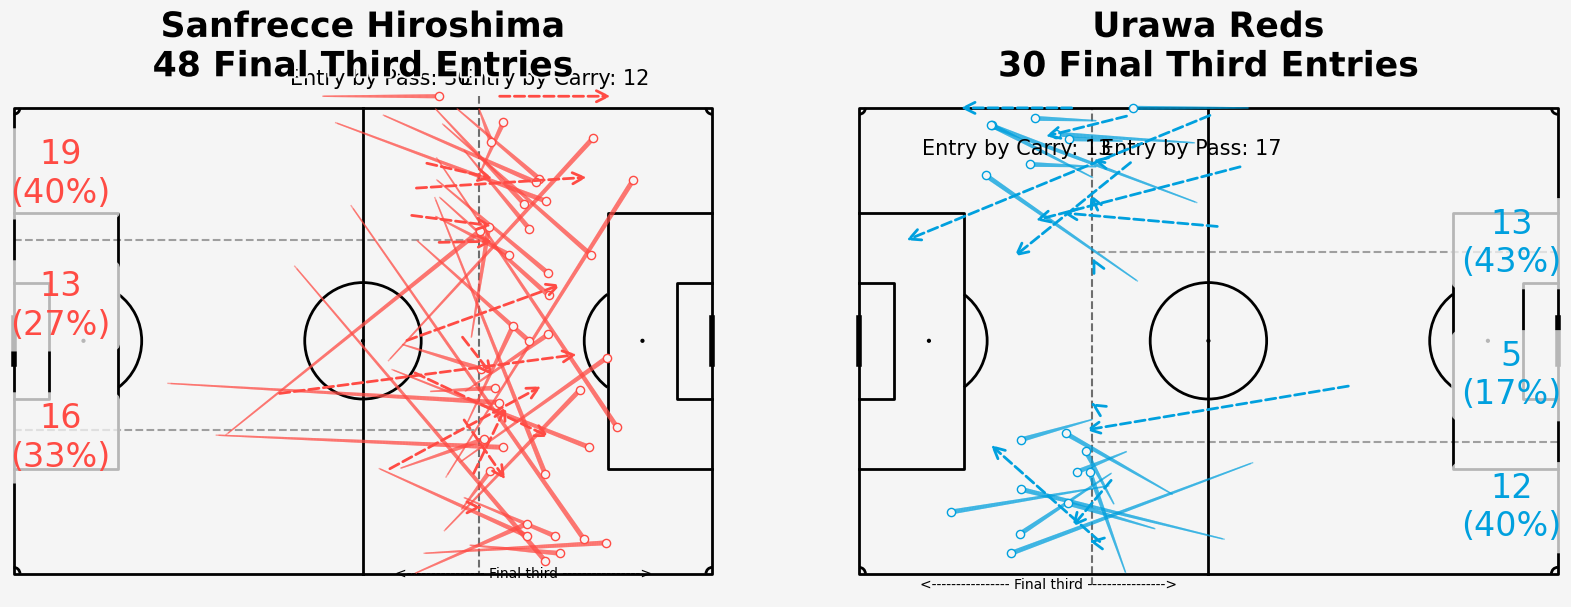

In [95]:
def Final_third_entry(ax, team_name, col):
    dfpass = df[(df['team_name']==team_name) & (df['type_name']=='Pass') & (df['x']<80) & (df['end_x']>=80) & (df['pass_outcome_name']=='1') &
                (~df['play_pattern_name'].str.contains('From Free Kick'))]
    dfcarry = df[(df['team_name']==team_name) & (df['type_name']=='Carry') & (df['x']<80) & (df['carry_end_x']>=80)]
    pitch = Pitch(pitch_type='statsbomb', pitch_color=bg_color, line_color=line_color, linewidth=2,
                          corner_arcs=True)
    pitch.draw(ax=ax)
    ax.set_xlim(-0.5, 120.5)
    # ax.set_ylim(-0.5, 68.5)

    if team_name == ateamName:
        ax.invert_xaxis()
        ax.invert_yaxis()

    pass_count = len(dfpass) + len(dfcarry)

    # calculating the counts
    left_entry = len(dfpass[dfpass['y']>=53.33]) + len(dfcarry[dfcarry['y']>=53.33])
    mid_entry = len(dfpass[(dfpass['y']>25.67) & (dfpass['y']<53.33)]) + len(dfcarry[(dfcarry['y']>=25.67) & (dfcarry['y']<53.33)])
    right_entry = len(dfpass[(dfpass['y']>=0) & (dfpass['y']<25.67)]) + len(dfcarry[(dfcarry['y']>=0) & (dfcarry['y']<25.67)])
    left_percentage = round((left_entry/pass_count)*100)
    mid_percentage = round((mid_entry/pass_count)*100)
    right_percentage = round((right_entry/pass_count)*100)

    ax.hlines(22.67, xmin=0, xmax=80, colors=line_color, linestyle='dashed', alpha=0.35)
    ax.hlines(55.33, xmin=0, xmax=80, colors=line_color, linestyle='dashed', alpha=0.35)
    ax.vlines(80, ymin=-2, ymax=80, colors=line_color, linestyle='dashed', alpha=0.55)

    # showing the texts in the pitch
    bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="None", facecolor=bg_color, alpha=0.75)
    if col == hcol:
        ax.text(8, 11.335, f'{right_entry}\n({right_percentage}%)', color=hcol, fontsize=24, va='center', ha='center', bbox=bbox_props)
        ax.text(8, 34, f'{mid_entry}\n({mid_percentage}%)', color=hcol, fontsize=24, va='center', ha='center', bbox=bbox_props)
        ax.text(8, 56.675, f'{left_entry}\n({left_percentage}%)', color=hcol, fontsize=24, va='center', ha='center', bbox=bbox_props)
    else:
        ax.text(8, 11.335, f'{right_entry}\n({right_percentage}%)', color=acol, fontsize=24, va='center', ha='center', bbox=bbox_props)
        ax.text(8, 34, f'{mid_entry}\n({mid_percentage}%)', color=acol, fontsize=24, va='center', ha='center', bbox=bbox_props)
        ax.text(8, 56.675, f'{left_entry}\n({left_percentage}%)', color=acol, fontsize=24, va='center', ha='center', bbox=bbox_props)

    # plotting the passes
    pro_pass = pitch.lines(dfpass.x, dfpass.y, dfpass.end_x, dfpass.end_y, lw=3.5, comet=True, color=col, ax=ax, alpha=0.5)
    # plotting some scatters at the end of each pass
    pro_pass_end = pitch.scatter(dfpass.end_x, dfpass.end_y, s=35, edgecolor=col, linewidth=1, color=bg_color, zorder=2, ax=ax)
    # plotting carries
    for index, row in dfcarry.iterrows():
        arrow = patches.FancyArrowPatch((row['x'], row['y']), (row['carry_end_x'], row['carry_end_y']), arrowstyle='->', color=col, zorder=4, mutation_scale=20, 
                                        alpha=1, linewidth=2, linestyle='--')
        ax.add_patch(arrow)

    counttext = f"{pass_count} Final Third Entries"

    # Heading and other texts
    if col == hcol:
        ax.set_title(f"{hteamName}\n{counttext}", color=line_color, fontsize=25, fontweight='bold', path_effects=path_eff)
        ax.text(87.5, 80, '<---------------- Final third ---------------->', color=line_color, ha='center', va='center')
        pitch.lines(53, -2, 73, -2, lw=3, transparent=True, comet=True, color=col, ax=ax, alpha=0.5)
        ax.scatter(73,-2, s=35, edgecolor=col, linewidth=1, color=bg_color, zorder=2)
        arrow = patches.FancyArrowPatch((83, -2), (103, -2), arrowstyle='->', color=col, zorder=4, mutation_scale=20, 
                                        alpha=1, linewidth=2, linestyle='--')
        ax.add_patch(arrow)
        ax.text(63, -5, f'Entry by Pass: {len(dfpass)}', fontsize=15, color=line_color, ha='center', va='center')
        ax.text(93, -5, f'Entry by Carry: {len(dfcarry)}', fontsize=15, color=line_color, ha='center', va='center')
        
    else:
        ax.set_title(f"{ateamName}\n{counttext}", color=line_color, fontsize=25, fontweight='bold', path_effects=path_eff)
        ax.text(87.5, -2, '<---------------- Final third ---------------->', color=line_color, ha='center', va='center')
        pitch.lines(53, 80, 73, 80, lw=3, transparent=True, comet=True, color=col, ax=ax, alpha=0.5)
        ax.scatter(73,80, s=35, edgecolor=col, linewidth=1, color=bg_color, zorder=2)
        arrow = patches.FancyArrowPatch((83, 80), (103, 80), arrowstyle='->', color=col, zorder=4, mutation_scale=20, 
                                        alpha=1, linewidth=2, linestyle='--')
        ax.add_patch(arrow)
        ax.text(63, 73, f'Entry by Pass: {len(dfpass)}', fontsize=15, color=line_color, ha='center', va='center')
        ax.text(93, 73, f'Entry by Carry: {len(dfcarry)}', fontsize=15, color=line_color, ha='center', va='center')

    return {
        'Team_Name': team_name,
        'Total_Final_Third_Entries': pass_count,
        'Final_Third_Entries_From_Left': left_entry,
        'Final_Third_Entries_From_Center': mid_entry,
        'Final_Third_Entries_From_Right': right_entry,
        'Entry_By_Pass': len(dfpass),
        'Entry_By_Carry': len(dfcarry)
    }

fig,axs=plt.subplots(1,2, figsize=(20,10), facecolor=bg_color)
final_third_entry_stats_home = Final_third_entry(axs[0], hteamName, hcol)
final_third_entry_stats_away = Final_third_entry(axs[1], ateamName, acol)
final_third_entry_stats_list = []
final_third_entry_stats_list.append(final_third_entry_stats_home)
final_third_entry_stats_list.append(final_third_entry_stats_away)
final_third_entry_stats_df = pd.DataFrame(final_third_entry_stats_list)

In [96]:
final_third_entry_stats_df

,Team_Name,Total_Final_Third_Entries,Final_Third_Entries_From_Left,Final_Third_Entries_From_Center,Final_Third_Entries_From_Right,Entry_By_Pass,Entry_By_Carry
0,Sanfrecce Hiroshima,48,16,13,19,36,12
1,Urawa Reds,30,13,5,12,17,13


Zone14 & Half-Space Passes

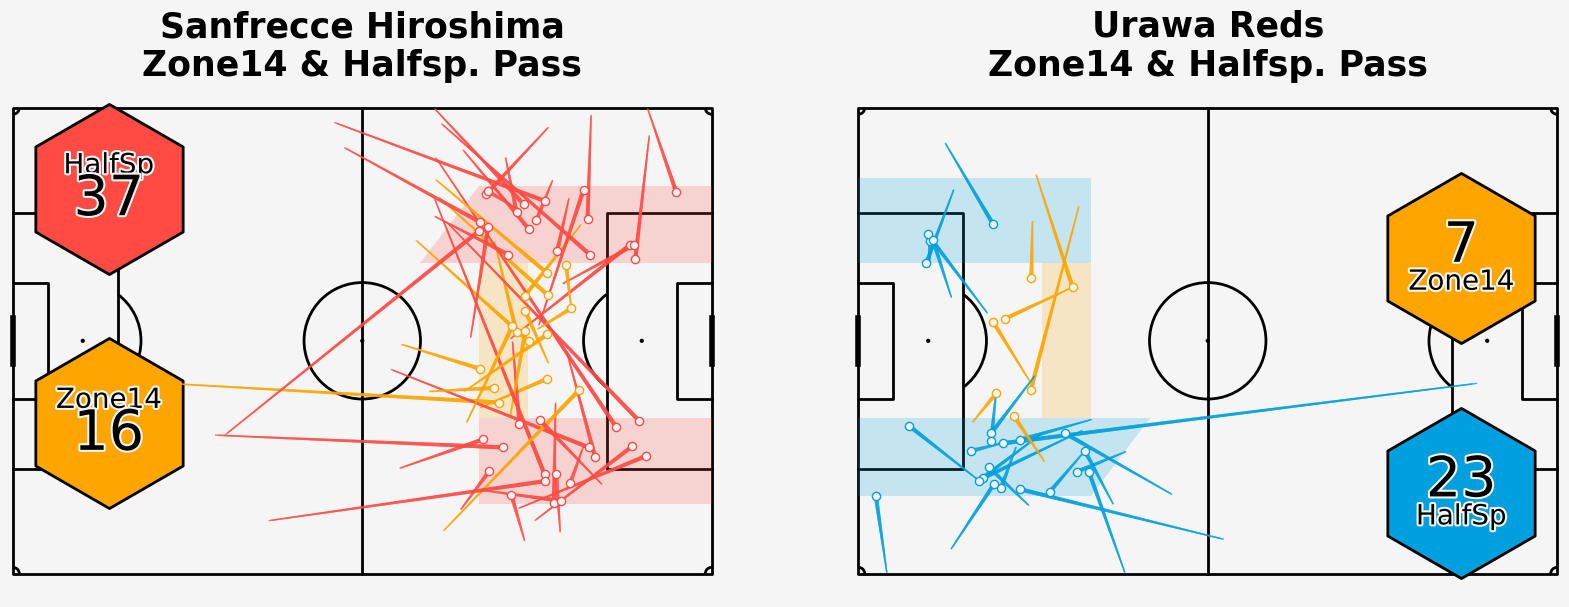

In [97]:
def zone14hs(ax, team_name, col):
    dfhp = df[(df['team_name']==team_name) & (df['type_name']=='Pass') & (df['pass_outcome_name']=='1') & 
              (~df['play_pattern_name'].str.contains('CornerTaken|Freekick'))]
    
    pitch = Pitch(pitch_type='statsbomb', pitch_color=bg_color, line_color=line_color,  linewidth=2,
                          corner_arcs=True)
    pitch.draw(ax=ax)
    ax.set_xlim(-0.5, 120.5)
    ax.set_facecolor(bg_color)
    if team_name == ateamName:
      ax.invert_xaxis()
      ax.invert_yaxis()

    # setting the count varibale
    z14 = 0
    hs = 0
    lhs = 0
    rhs = 0

    path_eff = [path_effects.Stroke(linewidth=3, foreground=bg_color), path_effects.Normal()]
    # iterating ecah pass and according to the conditions plotting only zone14 and half spaces passes
    for index, row in dfhp.iterrows():
        if row['end_x'] >= 80 and row['end_x'] <= 98.54 and row['end_y'] >= 26.66 and row['end_y'] <= 53.32:
            pitch.lines(row['x'], row['y'], row['end_x'], row['end_y'], color='orange', comet=True, lw=3, zorder=3, ax=ax, alpha=0.75)
            ax.scatter(row['end_x'], row['end_y'], s=35, linewidth=1, color=bg_color, edgecolor='orange', zorder=4)
            z14 += 1
        if row['end_x'] >= 80 and row['end_y'] >= 13.33 and row['end_y'] <= 26.66:
            pitch.lines(row['x'], row['y'], row['end_x'], row['end_y'], color=col, comet=True, lw=3, zorder=3, ax=ax, alpha=0.75)
            ax.scatter(row['end_x'], row['end_y'], s=35, linewidth=1, color=bg_color, edgecolor=col, zorder=4)
            hs += 1
            rhs += 1
        if row['end_x'] >= 80 and row['end_y'] >= 53.32 and row['end_y'] <= 67.95:
            pitch.lines(row['x'], row['y'], row['end_x'], row['end_y'], color=col, comet=True, lw=3, zorder=3, ax=ax, alpha=0.75)
            ax.scatter(row['end_x'], row['end_y'], s=35, linewidth=1, color=bg_color, edgecolor=col, zorder=4)
            hs += 1
            lhs += 1

    # coloring those zones in the pitch
    y_z14 = [26.66, 26.66, 53.32, 53.32]
    x_z14 = [80, 88.54, 88.54, 80]
    ax.fill(x_z14, y_z14, 'orange', alpha=0.2, label='Zone14')

    y_rhs = [13.33, 13.33, 26.66, 26.66]
    x_rhs = [80, 120, 120, 70]
    ax.fill(x_rhs, y_rhs, col, alpha=0.2, label='HalfSpaces')

    y_lhs = [53.32, 53.32, 67.95, 67.95]
    x_lhs = [80, 120, 120, 80]
    ax.fill(x_lhs, y_lhs, col, alpha=0.2, label='HalfSpaces')

    # showing the counts in an attractive way
    z14name = "Zone14"
    hsname = "HalfSp"
    z14count = f"{z14}"
    hscount = f"{hs}"
    ax.scatter(16.46, 13.85, color=col, s=15000, edgecolor=line_color, linewidth=2, alpha=1, marker='h')
    ax.scatter(16.46, 54.15, color='orange', s=15000, edgecolor=line_color, linewidth=2, alpha=1, marker='h')
    ax.text(16.46, 13.85-4, hsname, fontsize=20, color=line_color, ha='center', va='center', path_effects=path_eff)
    ax.text(16.46, 54.15-4, z14name, fontsize=20, color=line_color, ha='center', va='center', path_effects=path_eff)
    ax.text(16.46, 13.85+2, hscount, fontsize=40, color=line_color, ha='center', va='center', path_effects=path_eff)
    ax.text(16.46, 54.15+2, z14count, fontsize=40, color=line_color, ha='center', va='center', path_effects=path_eff)

    # Headings and other texts
    if col == hcol:
      ax.set_title(f"{hteamName}\nZone14 & Halfsp. Pass", color=line_color, fontsize=25, fontweight='bold')
    else:
      ax.set_title(f"{ateamName}\nZone14 & Halfsp. Pass", color=line_color, fontsize=25, fontweight='bold')

    return {
        'Team_Name': team_name,
        'Total_Passes_Into_Zone14': z14,
        'Passes_Into_Halfspaces': hs,
        'Passes_Into_Left_Halfspaces': lhs,
        'Passes_Into_Right_Halfspaces': rhs
    }

fig,axs=plt.subplots(1,2, figsize=(20,10), facecolor=bg_color)
zonal_passing_stats_home = zone14hs(axs[0], hteamName, hcol)
zonal_passing_stats_away = zone14hs(axs[1], ateamName, acol)
zonal_passing_stats_list = []
zonal_passing_stats_list.append(zonal_passing_stats_home)
zonal_passing_stats_list.append(zonal_passing_stats_away)
zonal_passing_stats_df = pd.DataFrame(zonal_passing_stats_list)

In [98]:
zonal_passing_stats_df

,Team_Name,Total_Passes_Into_Zone14,Passes_Into_Halfspaces,Passes_Into_Left_Halfspaces,Passes_Into_Right_Halfspaces
0,Sanfrecce Hiroshima,16,37,18,19
1,Urawa Reds,7,23,5,18


Pass Ending Zone

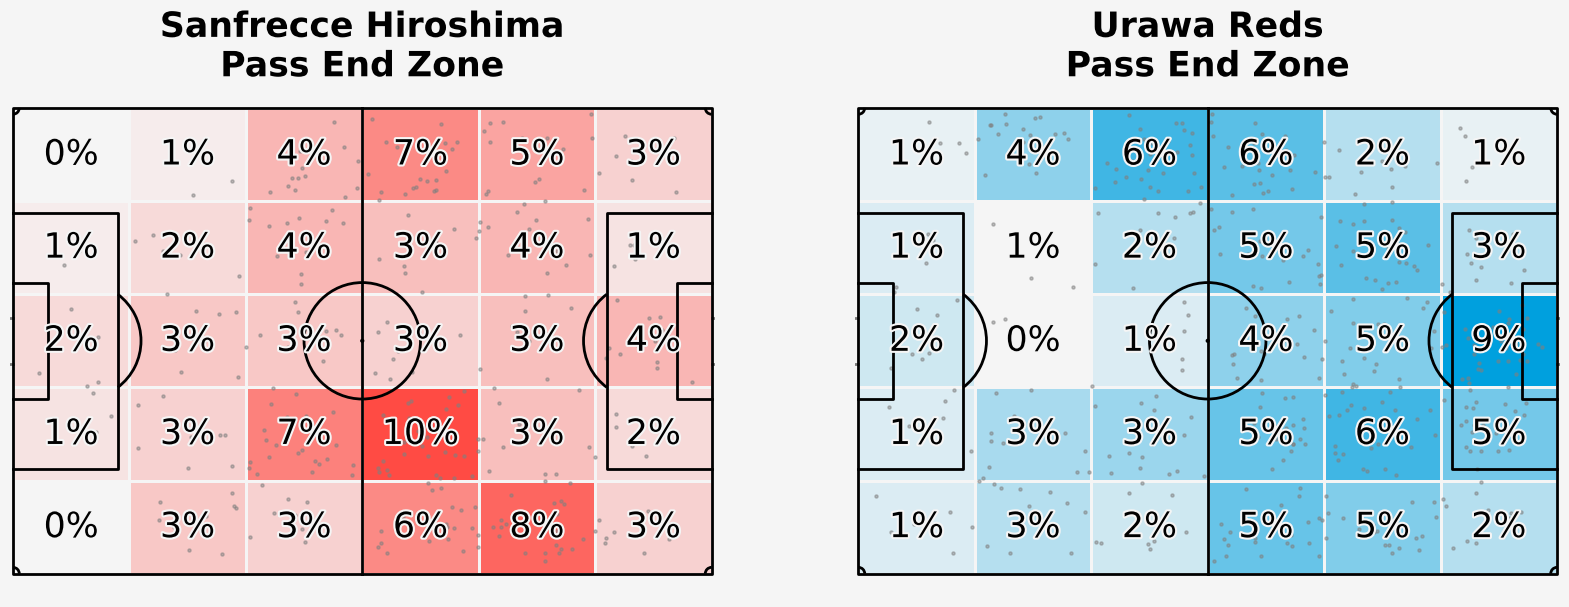

In [99]:
# setting the custom colormap
pearl_earring_cmaph = LinearSegmentedColormap.from_list("Pearl Earring - 10 colors",  [bg_color, hcol], N=20)
pearl_earring_cmapa = LinearSegmentedColormap.from_list("Pearl Earring - 10 colors",  [bg_color, acol], N=20)

path_eff = [path_effects.Stroke(linewidth=3, foreground=bg_color), path_effects.Normal()]

def Pass_end_zone(ax, team_name, cm):
    pez = df[(df['team_name'] == team_name) & (df['type_name'] == 'Pass') & (df['pass_outcome_name'] == '1')]
    pitch = Pitch(pitch_type='statsbomb', line_color=line_color, goal_type='box', goal_alpha=.5, corner_arcs=True, line_zorder=2, pitch_color=bg_color, linewidth=2)
    pitch.draw(ax=ax)
    ax.set_xlim(-0.5, 120.5)
    if team_name == ateamName:
      ax.invert_xaxis()
      ax.invert_yaxis()

    pearl_earring_cmap = cm
    # binning the data points
    # bin_statistic = pitch.bin_statistic_positional(df.end_x, df.end_y, statistic='count', positional='full', normalize=True)
    bin_statistic = pitch.bin_statistic(pez.end_x, pez.end_y, bins=(6, 5), normalize=True)
    pitch.heatmap(bin_statistic, ax=ax, cmap=pearl_earring_cmap, edgecolors=bg_color)
    pitch.scatter(pez.end_x, pez.end_y, c='gray', alpha=0.5, s=5, ax=ax)
    labels = pitch.label_heatmap(bin_statistic, color=line_color, fontsize=25, ax=ax, ha='center', va='center', str_format='{:.0%}', path_effects=path_eff)

    # Headings and other texts
    if team_name == hteamName:
      ax.set_title(f"{hteamName}\nPass End Zone", color=line_color, fontsize=25, fontweight='bold', path_effects=path_eff)
    else:
      ax.set_title(f"{ateamName}\nPass End Zone", color=line_color, fontsize=25, fontweight='bold', path_effects=path_eff)

fig,axs=plt.subplots(1,2, figsize=(20,10), facecolor=bg_color)
Pass_end_zone(axs[0], hteamName, pearl_earring_cmaph)
Pass_end_zone(axs[1], ateamName, pearl_earring_cmapa)

In [100]:
def pass_end_zone_counts(team_name):
    # Filter successful passes by team
    passes = df[(df['team_name'] == team_name) & (df['type_name'] == 'Pass') & (df['pass_outcome_name'] == '1')]

    # Create zones
    conditions = [
        (passes['end_x'] < 40),
        (passes['end_x'] >= 40) & (passes['end_x'] < 80),
        (passes['end_x'] >= 80)
    ]
    third_labels = ['Defensive Third', 'Middle Third', 'Final Third']
    passes['zone'] = np.select(conditions, third_labels)

    # Horizontal zones (left/mid/right)
    h_conditions = [
        (passes['end_y'] < 22.67),
        (passes['end_y'] >= 22.67) & (passes['end_y'] < 45.33),
        (passes['end_y'] >= 45.33)
    ]
    h_labels = ['Left', 'Center', 'Right']
    passes['side'] = np.select(h_conditions, h_labels)

    # Count number of passes per zone and side
    summary = passes.groupby(['zone', 'side']).size().unstack(fill_value=0)

    # Total per zone
    summary['Total'] = summary.sum(axis=1)

    return summary.reset_index()

# Example usage:
home_pass_zone_df = pass_end_zone_counts(hteamName)
away_pass_zone_df = pass_end_zone_counts(ateamName)

# Display
import pandas as pd
from IPython.display import display
display(pd.concat([home_pass_zone_df.assign(Team=hteamName), away_pass_zone_df.assign(Team=ateamName)]))


C:\Users\lahd2\AppData\Local\Temp\ipykernel_31424\3907210031.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  passes['zone'] = np.select(conditions, third_labels)
C:\Users\lahd2\AppData\Local\Temp\ipykernel_31424\3907210031.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  passes['side'] = np.select(h_conditions, h_labels)
C:\Users\lahd2\AppData\Local\Temp\ipykernel_31424\3907210031.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

side,zone,Center,Left,Right,Total,Team
0,Defensive Third,18,3,25,46,Sanfrecce Hiroshima
1,Final Third,30,32,54,116,Sanfrecce Hiroshima
2,Middle Third,27,45,85,157,Sanfrecce Hiroshima
0,Defensive Third,85,48,56,189,Urawa Reds
1,Final Third,20,25,33,78,Urawa Reds
2,Middle Third,44,46,87,177,Urawa Reds


Chances Creating Zone

[True]
[]


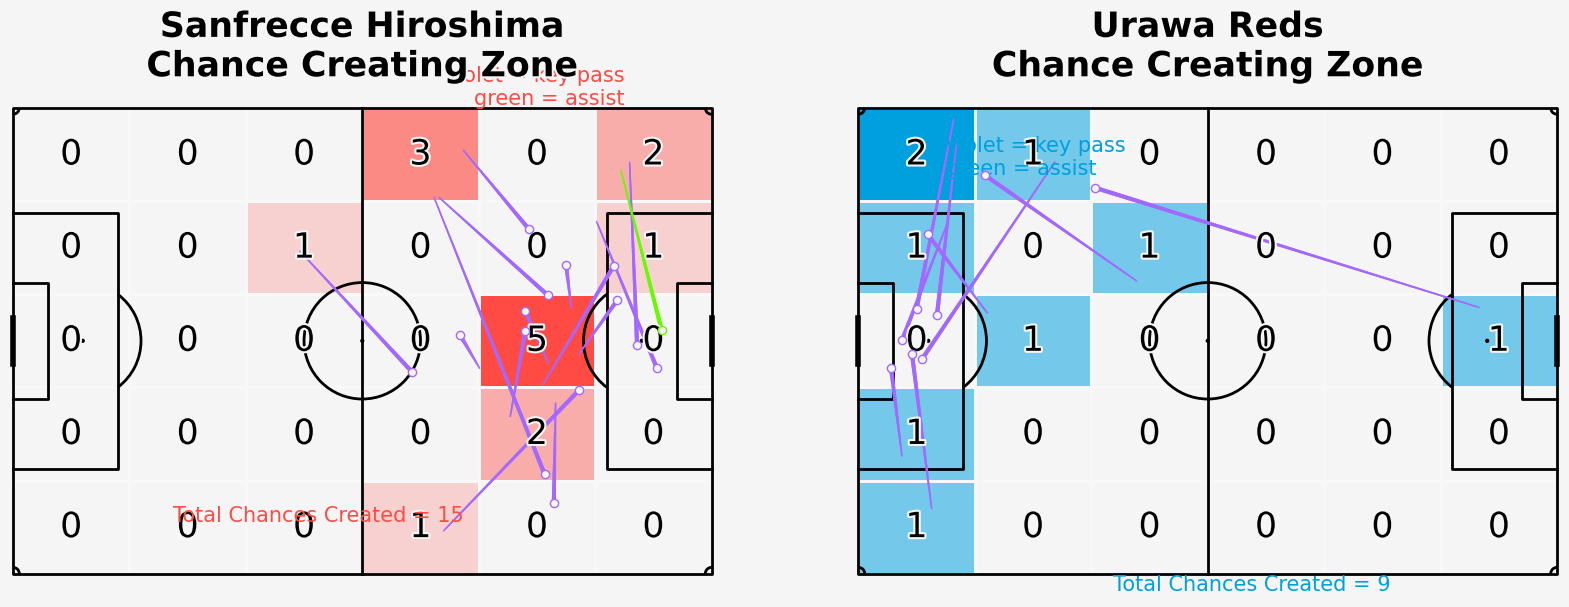

In [118]:
# setting the custom colormap
pearl_earring_cmaph = LinearSegmentedColormap.from_list("Pearl Earring - 10 colors", [bg_color, hcol], N=20)
pearl_earring_cmapa = LinearSegmentedColormap.from_list("Pearl Earring - 10 colors", [bg_color, acol], N=20)

path_eff = [path_effects.Stroke(linewidth=3, foreground=bg_color), path_effects.Normal()]

def Chance_creating_zone(ax, team_name, cm, col):
    # Filter key passes
    ccp = df[
    (df['type_name'] == 'Pass') &
    (df['pass_outcome_name'] == '1') &
    (df['team_name'] == team_name) &
    (
        df['pass_shot_assist'].astype(str).str.contains('TRUE|True', case=False, na=False) |
        df['pass_goal_assist'].astype(str).str.contains('TRUE|True', case=False, na=False)
    ) &
    (~df['play_pattern_name'].astype(str).str.contains('From Corner|From Free Kick', case=False, na=False))
]
    print(ccp['pass_goal_assist'].dropna().unique())




    pitch = Pitch(pitch_type='statsbomb', line_color=line_color, corner_arcs=True,
                  line_zorder=2, pitch_color=bg_color, linewidth=2)
    pitch.draw(ax=ax)
    ax.set_xlim(-0.5, 120.5)

    if team_name == ateamName:
        ax.invert_xaxis()
        ax.invert_yaxis()

    cc = 0  # total chances
    pearl_earring_cmap = cm

    # Heatmap binning
    bin_statistic = pitch.bin_statistic(ccp['x'], ccp['y'], bins=(6, 5), statistic='count', normalize=False)
    pitch.heatmap(bin_statistic, ax=ax, cmap=pearl_earring_cmap, edgecolors='#f8f8f8')

    # Draw lines and end points
    for _, row in ccp.iterrows():
        is_assist = row.get('pass_goal_assist') is True
        color = green if is_assist else violet
        pitch.lines(row['x'], row['y'], row['end_x'], row['end_y'], color=color, comet=True, lw=3, zorder=3, ax=ax)
        ax.scatter(row['end_x'], row['end_y'], s=35, linewidth=1, color=bg_color, edgecolor=color, zorder=4)
        cc += 1

    # Add value labels on heatmap
    pitch.label_heatmap(bin_statistic, color=line_color, fontsize=25, ax=ax,
                        ha='center', va='center', str_format='{:.0f}', path_effects=path_eff)

    # Titles & Texts
    if col == hcol:
        ax.text(105, -3.5, "violet = key pass\ngreen = assist", color=hcol, size=15, ha='right', va='center')
        ax.text(52.5, 70, f"Total Chances Created = {cc}", color=col, fontsize=15, ha='center', va='center')
        ax.set_title(f"{hteamName}\nChance Creating Zone", color=line_color, fontsize=25, fontweight='bold', path_effects=path_eff)
    else:
        ax.text(105, 71.5, "violet = key pass\ngreen = assist", color=acol, size=15, ha='left', va='center')
        ax.text(52.5, -2, f"Total Chances Created = {cc}", color=col, fontsize=15, ha='center', va='center')
        ax.set_title(f"{ateamName}\nChance Creating Zone", color=line_color, fontsize=25, fontweight='bold', path_effects=path_eff)

    return {
        'Team_Name': team_name,
        'Total_Chances_Created': cc
    }


fig,axs=plt.subplots(1,2, figsize=(20,10), facecolor=bg_color)
chance_creating_stats_home = Chance_creating_zone(axs[0], hteamName, pearl_earring_cmaph, hcol)
chance_creating_stats_away = Chance_creating_zone(axs[1], ateamName, pearl_earring_cmapa, acol)
chance_creating_stats_list = []
chance_creating_stats_list.append(chance_creating_stats_home)
chance_creating_stats_list.append(chance_creating_stats_away)
chance_creating_stats_df = pd.DataFrame(chance_creating_stats_list)

In [ ]:
chance_creating_stats_df

,Team_Name,Total_Chances_Created
0,Sanfrecce Hiroshima,15
1,Urawa Reds,12


Box Entry

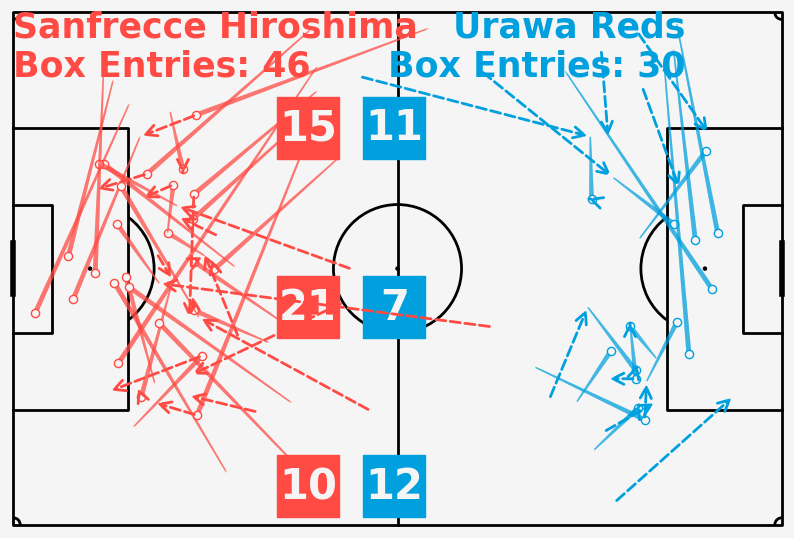

In [120]:
def box_entry(ax):
    bentry = df[
        (
            ((df['type_name'] == 'Pass') & (df['pass_outcome_name'] == '1')) |
            ((df['type_name'] == 'Carry'))
        ) &
        (
            (
                ((df['type_name'] == 'Pass') & (df['end_x'] >= 88.5) & (df['end_y'].between(16, 64.2))) |
                ((df['type_name'] == 'Carry') & (df['carry_end_x'] >= 88.5) & (df['carry_end_y'].between(16, 64.2)))
            )
        ) &
        ~(
            (df['x'] >= 101.1) & (df['y'].between(16, 64.2))
        ) &
        (~df['play_pattern_name'].astype(str).str.contains('From Corner|From Free Kick|From Throw In', na=False))
    ]
    hbentry = bentry[bentry['team_name']==hteamName]
    abentry = bentry[bentry['team_name']==ateamName]

    hrigt = hbentry[hbentry['y']<80/3]
    hcent = hbentry[(hbentry['y']>=80/3) & (hbentry['y']<=160/3)]
    hleft = hbentry[hbentry['y']>160/3]

    arigt = abentry[(abentry['y']<80/3)]
    acent = abentry[(abentry['y']>=80/3) & (abentry['y']<=160/3)]
    aleft = abentry[(abentry['y']>160/3)]

    pitch = Pitch(pitch_type='statsbomb', line_color=line_color, corner_arcs=True, line_zorder=2, pitch_color=bg_color, linewidth=2)
    pitch.draw(ax=ax)
    ax.set_xlim(-0.5, 120.5)
    ax.set_ylim(-0.5, 80.5)

    for index, row in bentry.iterrows():
    # Determine team color and apply flip for home team
        if row['team_name'] == ateamName:
            color = acol
            flip = False
        elif row['team_name'] == hteamName:
            color = hcol
            flip = True
        else:
            continue  # Skip invalid teams

        # Select correct coordinates based on action type
        if row['type_name'] == 'Pass':
            x, y = row['x'], row['y']
            end_x, end_y = row['end_x'], row['end_y']
        elif row['type_name'] == 'Carry':
            x, y = row['x'], row['y']
            end_x, end_y = row['carry_end_x'], row['carry_end_y']
        else:
            continue  # Skip anything else

        # Flip coordinates for home team
        if flip:
            x, y = 120 - x, 80 - y
            end_x, end_y = 120 - end_x, 80 - end_y

        # Draw the actions
        if row['type_name'] == 'Pass':
            pitch.lines(x, y, end_x, end_y, lw=3.5, comet=True, color=color, ax=ax, alpha=0.5)
            pitch.scatter(end_x, end_y, s=35, edgecolor=color, linewidth=1, color=bg_color, zorder=2, ax=ax)
        elif row['type_name'] == 'Carry':
            arrow = patches.FancyArrowPatch(
                (x, y), (end_x, end_y),
                arrowstyle='->', color=color,
                zorder=4, mutation_scale=20,
                alpha=1, linewidth=2, linestyle='--'
            )
            ax.add_patch(arrow)


    
    ax.text(0, 69, f'{hteamName}\nBox Entries: {len(hbentry)}', color=hcol, fontsize=25, fontweight='bold', ha='left', va='bottom')
    ax.text(105, 69, f'{ateamName}\nBox Entries: {len(abentry)}', color=acol, fontsize=25, fontweight='bold', ha='right', va='bottom')

    ax.scatter(46, 6, s=2000, marker='s', color=hcol, zorder=3)
    ax.scatter(46, 34, s=2000, marker='s', color=hcol, zorder=3)
    ax.scatter(46, 62, s=2000, marker='s', color=hcol, zorder=3)
    ax.text(46, 6, f'{len(hleft)}', fontsize=30, fontweight='bold', color=bg_color, ha='center', va='center')
    ax.text(46, 34, f'{len(hcent)}', fontsize=30, fontweight='bold', color=bg_color, ha='center', va='center')
    ax.text(46, 62, f'{len(hrigt)}', fontsize=30, fontweight='bold', color=bg_color, ha='center', va='center')

    ax.scatter(59.5, 6, s=2000, marker='s', color=acol, zorder=3)
    ax.scatter(59.5, 34, s=2000, marker='s', color=acol, zorder=3)
    ax.scatter(59.5, 62, s=2000, marker='s', color=acol, zorder=3)
    ax.text(59.5, 6, f'{len(arigt)}', fontsize=30, fontweight='bold', color=bg_color, ha='center', va='center')
    ax.text(59.5, 34, f'{len(acent)}', fontsize=30, fontweight='bold', color=bg_color, ha='center', va='center')
    ax.text(59.5, 62, f'{len(aleft)}', fontsize=30, fontweight='bold', color=bg_color, ha='center', va='center')

    home_data = {
        'Team_Name': hteamName,
        'Total_Box_Entries': len(hbentry),
        'Box_Entry_From_Left': len(hleft),
        'Box_Entry_From_Center': len(hcent),
        'Box_Entry_From_Right': len(hrigt)
    }
    
    away_data = {
        'Team_Name': ateamName,
        'Total_Box_Entries': len(abentry),
        'Box_Entry_From_Left': len(aleft),
        'Box_Entry_From_Center': len(acent),
        'Box_Entry_From_Right': len(arigt)
    }
    
    return [home_data, away_data]

fig,ax=plt.subplots(figsize=(10,10), facecolor=bg_color)
box_entry_stats = box_entry(ax)
box_entry_stats_df = pd.DataFrame(box_entry_stats)

In [121]:
box_entry_stats_df

,Team_Name,Total_Box_Entries,Box_Entry_From_Left,Box_Entry_From_Center,Box_Entry_From_Right
0,Sanfrecce Hiroshima,46,10,21,15
1,Urawa Reds,30,11,7,12


Cross

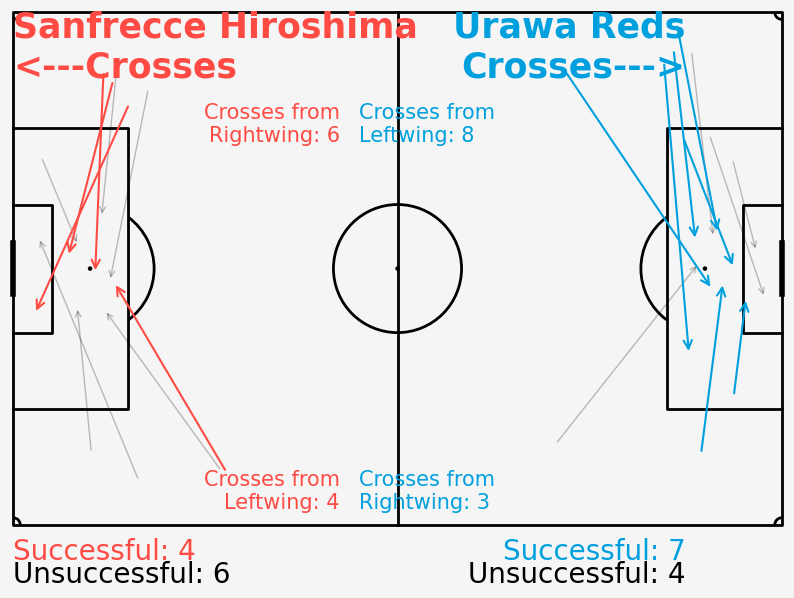

In [162]:
def Crosses(ax):
    pitch = Pitch(pitch_type='statsbomb', corner_arcs=True, pitch_color=bg_color, line_color=line_color, linewidth=2)
    pitch.draw(ax=ax)
    ax.set_ylim(-0.5, 80.5)
    ax.set_xlim(-0.5, 120.5)

    # Filtering crosses correctly
    home_cross = df[
        (df['team_name'] == hteamName) &
        (df['type_name'] == 'Pass') &
        (df['pass_cross'].astype(str).str.lower() == 'true') &
        (~df['play_pattern_name'].astype(str).str.contains('From Corner', case=False, na=False))
    ]

    away_cross = df[
        (df['team_name'] == ateamName) &
        (df['type_name'] == 'Pass') &
        (df['pass_cross'].astype(str).str.lower() == 'true') &
        (~df['play_pattern_name'].astype(str).str.contains('From Corner', case=False, na=False))
    ]

    hsuc, hunsuc, asuc, aunsuc = 0, 0, 0, 0

    for _, row in home_cross.iterrows():
        arrow = patches.FancyArrowPatch(
            (120 - row['x'], 80 - row['y']), (120 - row['end_x'], 80 - row['end_y']),
            arrowstyle='->', mutation_scale=15 if row['pass_outcome_name'] == '1' else 10,
            color=hcol if row['pass_outcome_name'] == '1' else line_color,
            linewidth=1.5 if row['pass_outcome_name'] == '1' else 1,
            alpha=1 if row['pass_outcome_name'] == '1' else .25, zorder=3
        )
        ax.add_patch(arrow)
        hsuc += (row['pass_outcome_name'] == '1')
        hunsuc += (row['pass_outcome_name'] != '1')

    for _, row in away_cross.iterrows():
        arrow = patches.FancyArrowPatch(
            (row['x'], row['y']), (row['end_x'], row['end_y']),
            arrowstyle='->', mutation_scale=15 if row['pass_outcome_name'] == '1' else 10,
            color=acol if row['pass_outcome_name'] == '1' else line_color,
            linewidth=1.5 if row['pass_outcome_name'] == '1' else 1,
            alpha=1 if row['pass_outcome_name'] == '1' else .25, zorder=3
        )
        ax.add_patch(arrow)
        asuc += (row['pass_outcome_name'] == '1')
        aunsuc += (row['pass_outcome_name'] != '1')

    home_left = len(home_cross[home_cross['y'] >= 40])
    home_right = len(home_cross[home_cross['y'] < 40])
    away_left = len(away_cross[away_cross['y'] >= 40])
    away_right = len(away_cross[away_cross['y'] < 40])

    # Annotations
    ax.text(51, 2, f"Crosses from\nLeftwing: {home_left}", color=hcol, fontsize=15, va='bottom', ha='right')
    ax.text(51, 66, f"Crosses from\nRightwing: {home_right}", color=hcol, fontsize=15, va='top', ha='right')
    ax.text(54, 66, f"Crosses from\nLeftwing: {away_left}", color=acol, fontsize=15, va='top', ha='left')
    ax.text(54, 2, f"Crosses from\nRightwing: {away_right}", color=acol, fontsize=15, va='bottom', ha='left')

    ax.text(0, -2, f"Successful: {hsuc}", color=hcol, fontsize=20, ha='left', va='top')
    ax.text(0, -5.5, f"Unsuccessful: {hunsuc}", color=line_color, fontsize=20, ha='left', va='top')
    ax.text(105, -2, f"Successful: {asuc}", color=acol, fontsize=20, ha='right', va='top')
    ax.text(105, -5.5, f"Unsuccessful: {aunsuc}", color=line_color, fontsize=20, ha='right', va='top')

    ax.text(0, 70, f"{hteamName}\n<---Crosses", color=hcol, size=25, ha='left', fontweight='bold')
    ax.text(105, 70, f"{ateamName}\nCrosses--->", color=acol, size=25, ha='right', fontweight='bold')

    home_data = {
        'Team_Name': hteamName,
        'Total_Cross': hsuc + hunsuc,
        'Successful_Cross': hsuc,
        'Unsuccessful_Cross': hunsuc,
        'Cross_From_LeftWing': home_left,
        'Cross_From_RightWing': home_right
    }

    away_data = {
        'Team_Name': ateamName,
        'Total_Cross': asuc + aunsuc,
        'Successful_Cross': asuc,
        'Unsuccessful_Cross': aunsuc,
        'Cross_From_LeftWing': away_left,
        'Cross_From_RightWing': away_right
    }

    return [home_data, away_data]

# Example usage
fig, ax = plt.subplots(figsize=(10, 10), facecolor=bg_color)
cross_stats = Crosses(ax)
cross_stats_df = pd.DataFrame(cross_stats)


In [163]:
cross_stats_df

,Team_Name,Total_Cross,Successful_Cross,Unsuccessful_Cross,Cross_From_LeftWing,Cross_From_RightWing
0,Sanfrecce Hiroshima,10,4,6,4,6
1,Urawa Reds,11,7,4,8,3


In [130]:
df_crosses = df[
    (df['team_name'] == hteamName) &
    (df['type_name'] == 'Pass') &
    (df['pass_cross'].astype(str) == 'TRUE')
]
print(df_crosses[['player_name', 'play_pattern_name']].head())


Empty DataFrame
Columns: [player_name, play_pattern_name]
Index: []


High Turnover

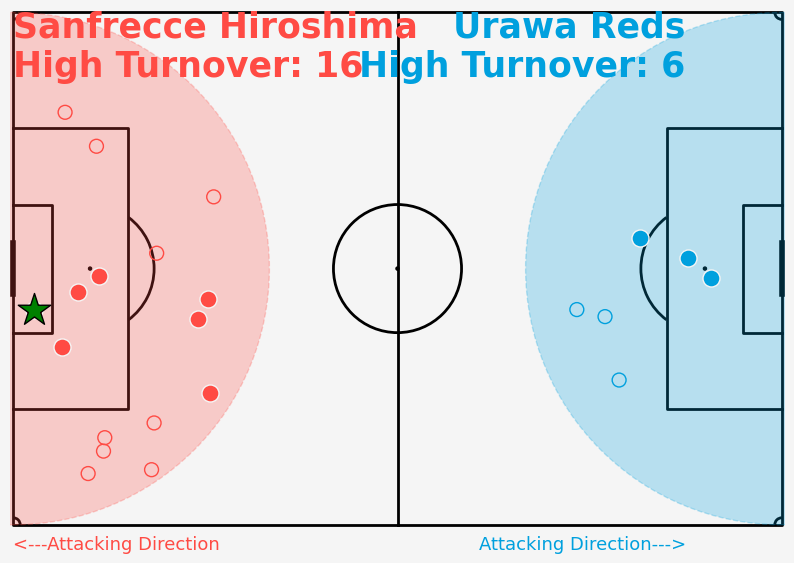

In [160]:
def HighTO(ax):
    pitch = Pitch(pitch_type='statsbomb', corner_arcs=True, pitch_color=bg_color, line_color=line_color, linewidth=2)
    pitch.draw(ax=ax)
    ax.set_ylim(-0.5, 80.5)
    ax.set_xlim(-0.5, 120.5)

    highTO = df.copy()
    highTO['Distance'] = ((highTO['x'] - 120) ** 2 + (highTO['y'] - 40) ** 2) ** 0.5

    def is_valid_turnover(row, team_name):
        return (
            row['team_name'] == team_name and
            row['Distance'] <= 40 and
            (
                row['type_name'] == 'Ball Recovery' or
                (row['type_name'] == 'Interception' and row.get('interception_outcome_name') in ['Success In Play', 'Won'])
            )
        )

    hgoal_count = agoal_count = hshot_count = ashot_count = hht_count = aht_count = 0

    def handle_turnovers(team_name, color, side='right'):
        nonlocal hgoal_count, agoal_count, hshot_count, ashot_count, hht_count, aht_count

        for i in range(len(highTO)):
            row = highTO.iloc[i]
            if is_valid_turnover(row, team_name):
                possession_id = row['team_name']

                # Check for goals
                for j in range(i + 1, len(highTO)):
                    next_row = highTO.iloc[j]
                    if next_row['team_name'] != possession_id or next_row['team_name'] != team_name:
                        break
                    if next_row['shot_outcome_name'] == 'Goal':
                        x, y = row['x'], row['y']
                        if side == 'left':
                            x, y = 120 - x, 80 - y
                        ax.scatter(x, y, s=600, marker='*', color='green', edgecolor='k', zorder=3)
                        if team_name == hteamName:
                            hgoal_count += 1
                        else:
                            agoal_count += 1
                        break

                # Check for shots
                for j in range(i + 1, len(highTO)):
                    next_row = highTO.iloc[j]
                    if next_row['team_name'] != possession_id or next_row['team_name'] != team_name:
                        break
                    if next_row['type_name'] == 'Shot':
                        x, y = row['x'], row['y']
                        if side == 'left':
                            x, y = 120 - x, 80 - y
                        ax.scatter(x, y, s=150, color=color, edgecolor=bg_color, zorder=2)
                        if team_name == hteamName:
                            hshot_count += 1
                        else:
                            ashot_count += 1
                        break

                # Basic turnover
                j = i + 1
                if (
                    j < len(highTO) and
                    highTO.iloc[j]['team_name'] == team_name and
                    highTO.iloc[j]['type_name'] not in ['Dispossessed']
                ):
                    x, y = row['x'], row['y']
                    if side == 'left':
                        x, y = 120 - x, 80 - y
                    ax.scatter(x, y, s=100, color='None', edgecolor=color)
                    if team_name == hteamName:
                        hht_count += 1
                    else:
                        aht_count += 1

    # Process for both teams
    handle_turnovers(hteamName, hcol, side='left')
    handle_turnovers(ateamName, acol, side='right')

    # Plotting the half circles
    ax.add_artist(plt.Circle((0, 40), 40, color=hcol, fill=True, alpha=0.25, linestyle='dashed'))
    ax.add_artist(plt.Circle((120, 40), 40, color=acol, fill=True, alpha=0.25, linestyle='dashed'))
    ax.set_aspect('equal', adjustable='box')

    # Headings and text
    ax.text(0, 70, f"{hteamName}\nHigh Turnover: {hht_count}", color=hcol, size=25, ha='left', fontweight='bold')
    ax.text(105, 70, f"{ateamName}\nHigh Turnover: {aht_count}", color=acol, size=25, ha='right', fontweight='bold')
    ax.text(0, -3, '<---Attacking Direction', color=hcol, fontsize=13, ha='left', va='center')
    ax.text(105, -3, 'Attacking Direction--->', color=acol, fontsize=13, ha='right', va='center')

    # Return stats as dictionary
    home_data = {
        'Team_Name': hteamName,
        'Total_High_Turnovers': hht_count,
        'Shot_Ending_High_Turnovers': hshot_count,
        'Goal_Ending_High_Turnovers': hgoal_count,
        'Opponent_Team_Name': ateamName
    }

    away_data = {
        'Team_Name': ateamName,
        'Total_High_Turnovers': aht_count,
        'Shot_Ending_High_Turnovers': ashot_count,
        'Goal_Ending_High_Turnovers': agoal_count,
        'Opponent_Team_Name': hteamName
    }

    return [home_data, away_data]


# Run and display
fig, ax = plt.subplots(figsize=(10, 10), facecolor=bg_color)
high_turnover_stats = HighTO(ax)
high_turnover_stats_df = pd.DataFrame(high_turnover_stats)


In [161]:
high_turnover_stats_df

,Team_Name,Total_High_Turnovers,Shot_Ending_High_Turnovers,Goal_Ending_High_Turnovers,Opponent_Team_Name
0,Sanfrecce Hiroshima,16,7,1,Urawa Reds
1,Urawa Reds,6,3,0,Sanfrecce Hiroshima


Congestion

C:\Users\h\AppData\Local\Temp\ipykernel_5864\4285275424.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['x'] = 105-df2['x']
C:\Users\h\AppData\Local\Temp\ipykernel_5864\4285275424.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['y'] =  68-df2['y']


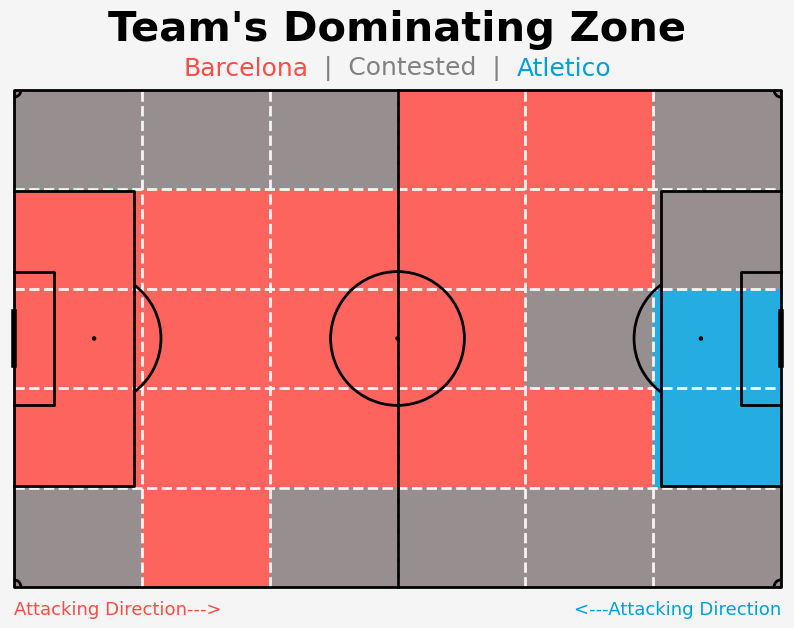

In [ ]:
def plot_congestion(ax):
    pcmap = LinearSegmentedColormap.from_list("Pearl Earring - 10 colors",  [acol, 'gray', hcol], N=20)
    df1 = df[(df['team_name']==hteamName) & (df['isTouch']==1) & (~df['qualifiers'].str.contains('CornerTaken|Freekick|ThrowIn'))]
    df2 = df[(df['team_name']==ateamName) & (df['isTouch']==1) & (~df['qualifiers'].str.contains('CornerTaken|Freekick|ThrowIn'))]
    df2['x'] = 120-df2['x']
    df2['y'] =  80-df2['y']
    pitch = Pitch(pitch_type='statsbomb', corner_arcs=True, pitch_color=bg_color, line_color=line_color, linewidth=2, line_zorder=6)
    pitch.draw(ax=ax)
    ax.set_ylim(-0.5,80.5)
    ax.set_xlim(-0.5,120.5)

    bin_statistic1 = pitch.bin_statistic(df1.Shoter_x, df1.Shoter_y, bins=(6,5), statistic='count', normalize=False)
    bin_statistic2 = pitch.bin_statistic(df2.Shoter_x, df2.Shoter_y, bins=(6,5), statistic='count', normalize=False)

    # Assuming 'cx' and 'cy' are as follows:
    cx = np.array([[ 8.75, 26.25, 43.75, 61.25, 78.75, 96.25],
               [ 8.75, 26.25, 43.75, 61.25, 78.75, 96.25],
               [ 8.75, 26.25, 43.75, 61.25, 78.75, 96.25],
               [ 8.75, 26.25, 43.75, 61.25, 78.75, 96.25],
               [ 8.75, 26.25, 43.75, 61.25, 78.75, 96.25]])

    cy = np.array([[61.2, 61.2, 61.2, 61.2, 61.2, 61.2],
               [47.6, 47.6, 47.6, 47.6, 47.6, 47.6],
               [34.0, 34.0, 34.0, 34.0, 34.0, 34.0],
               [20.4, 20.4, 20.4, 20.4, 20.4, 20.4],
               [ 6.8,  6.8,  6.8,  6.8,  6.8,  6.8]])

    # Flatten the arrays
    cx_flat = cx.flatten()
    cy_flat = cy.flatten()

    # Create a DataFrame
    df_cong = pd.DataFrame({'cx': cx_flat, 'cy': cy_flat})

    hd_values = []


    # Loop through the 2D arrays
    for i in range(bin_statistic1['statistic'].shape[0]):
        for j in range(bin_statistic1['statistic'].shape[1]):
            stat1 = bin_statistic1['statistic'][i, j]
            stat2 = bin_statistic2['statistic'][i, j]
        
            if (stat1 / (stat1 + stat2)) > 0.55:
                hd_values.append(1)
            elif (stat1 / (stat1 + stat2)) < 0.45:
                hd_values.append(0)
            else:
                hd_values.append(0.5)

    df_cong['hd']=hd_values
    bin_stat = pitch.bin_statistic(df_cong.cx, df_cong.cy, bins=(6,5), values=df_cong['hd'], statistic='sum', normalize=False)
    pitch.heatmap(bin_stat, ax=ax, cmap=pcmap, edgecolors='#000000', lw=0, zorder=3, alpha=0.85)

    ax_text(52.5, 71, s=f"<{hteamName}>  |  Contested  |  <{ateamName}>", highlight_textprops=[{'color':hcol}, {'color':acol}],
            color='gray', fontsize=18, ha='center', va='center', ax=ax)
    ax.set_title("Team's Dominating Zone", color=line_color, fontsize=30, fontweight='bold', y=1.075)
    ax.text(0,  -3, 'Attacking Direction--->', color=hcol, fontsize=13, ha='left', va='center')
    ax.text(105,-3, '<---Attacking Direction', color=acol, fontsize=13, ha='right', va='center')

    ax.vlines(1*(105/6), ymin=0, ymax=68, color=bg_color, lw=2, ls='--', zorder=5)
    ax.vlines(2*(105/6), ymin=0, ymax=68, color=bg_color, lw=2, ls='--', zorder=5)
    ax.vlines(3*(105/6), ymin=0, ymax=68, color=bg_color, lw=2, ls='--', zorder=5)
    ax.vlines(4*(105/6), ymin=0, ymax=68, color=bg_color, lw=2, ls='--', zorder=5)
    ax.vlines(5*(105/6), ymin=0, ymax=68, color=bg_color, lw=2, ls='--', zorder=5)

    ax.hlines(1*(68/5), xmin=0, xmax=105, color=bg_color, lw=2, ls='--', zorder=5)
    ax.hlines(2*(68/5), xmin=0, xmax=105, color=bg_color, lw=2, ls='--', zorder=5)
    ax.hlines(3*(68/5), xmin=0, xmax=105, color=bg_color, lw=2, ls='--', zorder=5)
    ax.hlines(4*(68/5), xmin=0, xmax=105, color=bg_color, lw=2, ls='--', zorder=5)
    
    return

fig,ax=plt.subplots(figsize=(10,10), facecolor=bg_color)
plot_congestion(ax)